In [11]:
# Scriptas ZIVE EKG filtravimo vizualiniam įvertinimui.  
# Atvaizduojami greta įrašas be filtravimo ir filtruotas.
# Abiejais atvejai įrašu rpeaks paimti iš json failo.

import numpy as np
import neurokit2 as nk
from neurokit2 import signal_filter

# import math
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import json
from pathlib import Path

from vertinimas_util import zive_read_file_1ch, AnalyseHeartrate, zive_read_df_data
from vertinimas_util import anotacijos, get_symbol_list, get_seq_start_end
from vertinimas_util import show_seq_ext_zive

# //////////////// NURODOMI PARAMETRAI /////////////////////////////////////////////////////
pd.set_option("display.max_rows", 6000)
pd.set_option("display.max_columns",200)
pd.set_option('display.width', 1000)

my_os=sys.platform

print("OS in my system : ",my_os)

if my_os != 'linux':
    OS = 'Windows'
else:  
    OS = 'Ubuntu'

# Bendras duomenų aplankas, kuriame patalpintas subfolderis name_db

if OS == 'Windows':
    Duomenu_aplankas = 'D:\\DI\\Data\\DI'   # variantas: Windows
else:
    Duomenu_aplankas = '/home/kesju/DI'   # arba variantas: UBUNTU, be Docker

# arba variantas: Windows, be Docker 
# Duomenu_aplankas = 'C:\DI\Data\MIT&ZIVE'

# Vaizdo parametrai
window_left_side = 100
window_right_side = 100
frag_start_fixed = 44600
# frag_end_fixed = 35000
frag_end_fixed = None
frag_window = 2600
win_flag= True

# Vietinės talpyklos aplankas 
db_folder = 'DUOM_2022_RUDUO_2'

#  Nuoroda į aplanką su ZIVE duomenų rinkiniu
db_path = Path(Duomenu_aplankas, db_folder)

# Nuoroda į aplanką su EKG įrašais (.npy) ir anotacijomis (.json)
rec_dir = Path(db_path, 'records_selected')



OS in my system :  linux



Scriptas ZIVE EKG filtravimo vizualiniam įvertinimui
Duomenų rinkinys:  /home/kesju/DI/DUOM_2022_RUDUO_2/records_selected

Zive įrašas:  1632342.032
signal_length=  127999 (127999,)
Vaizduojamos reikšmės intervale: 44600 127999
Lango plotis:  2600 Langų:  32

Išlyginta izolinija su butterworth

Anotacijų įraše (F ir U ignoruojamos):
{'N': 704}

Anotacijų S vietos: {}

Anotacijos V: {}
frag_nr = 0 44600 47200


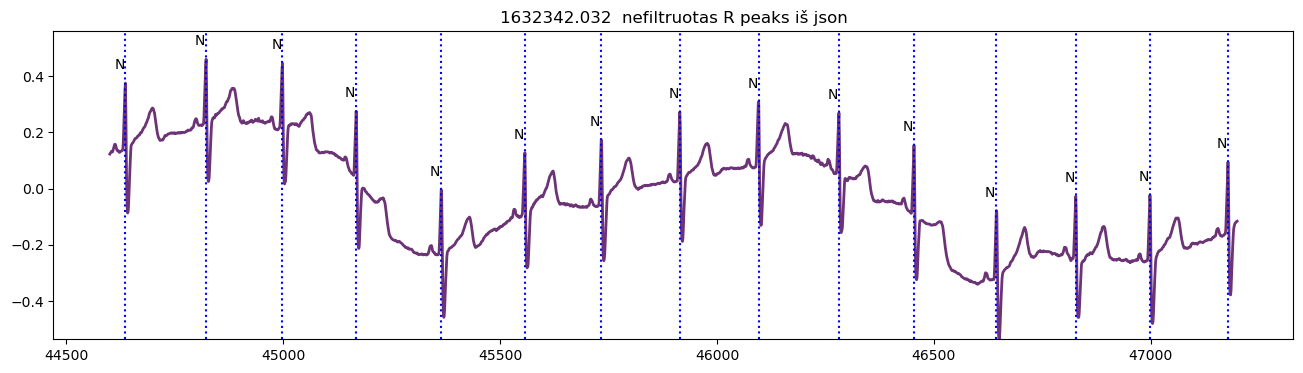

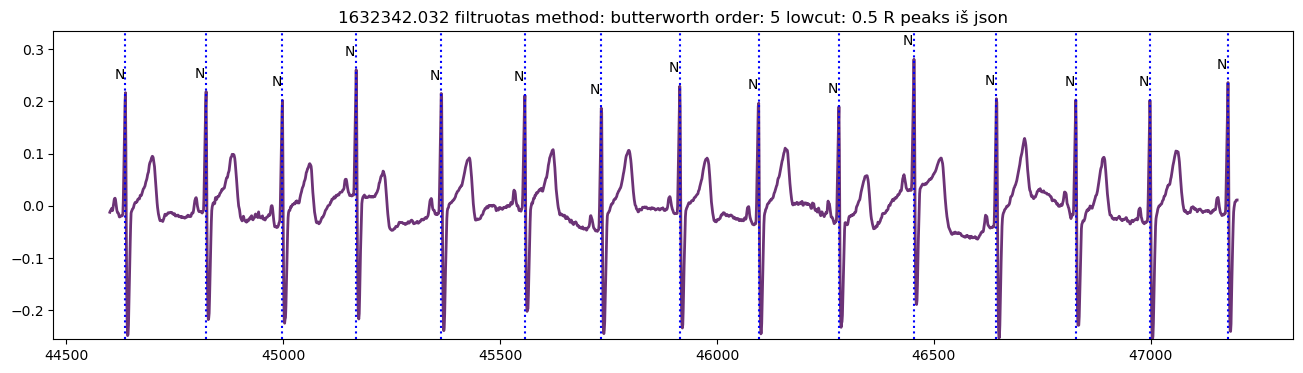

frag_nr = 1 47200 49800


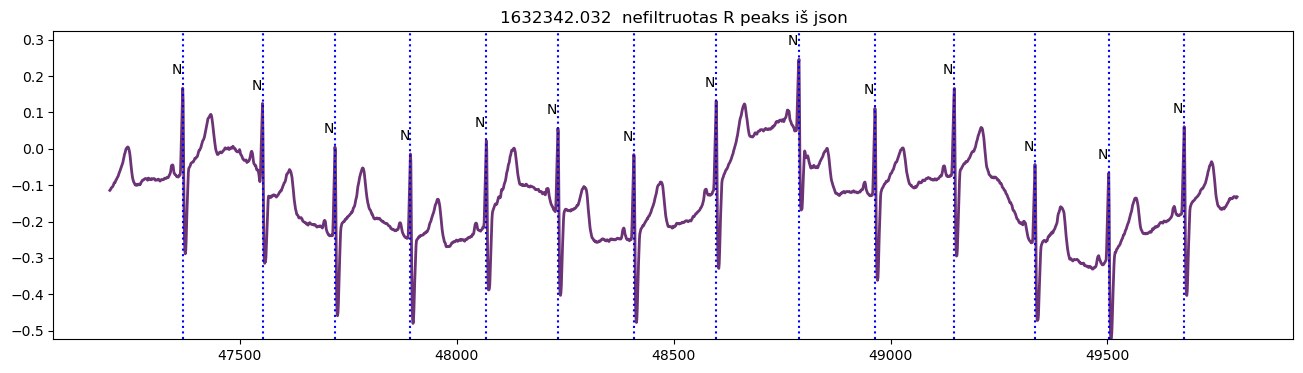

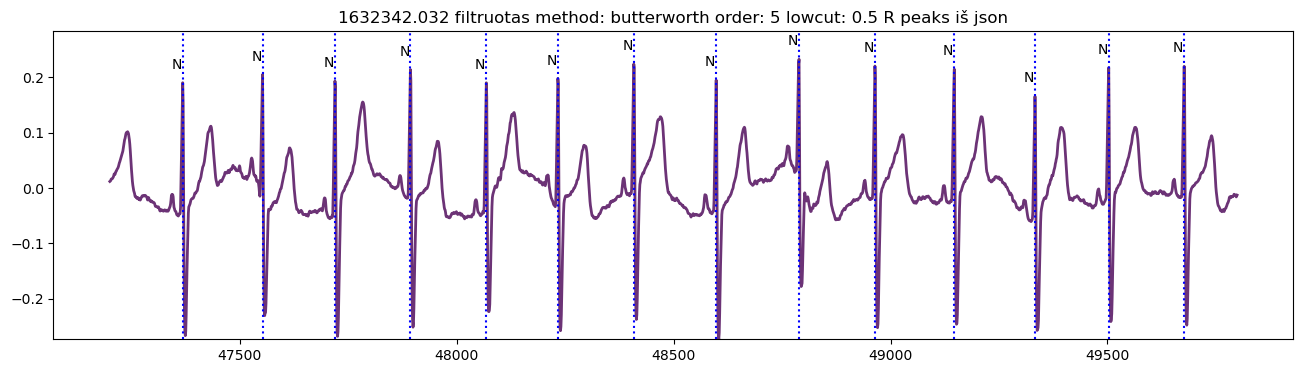

frag_nr = 2 49800 52400


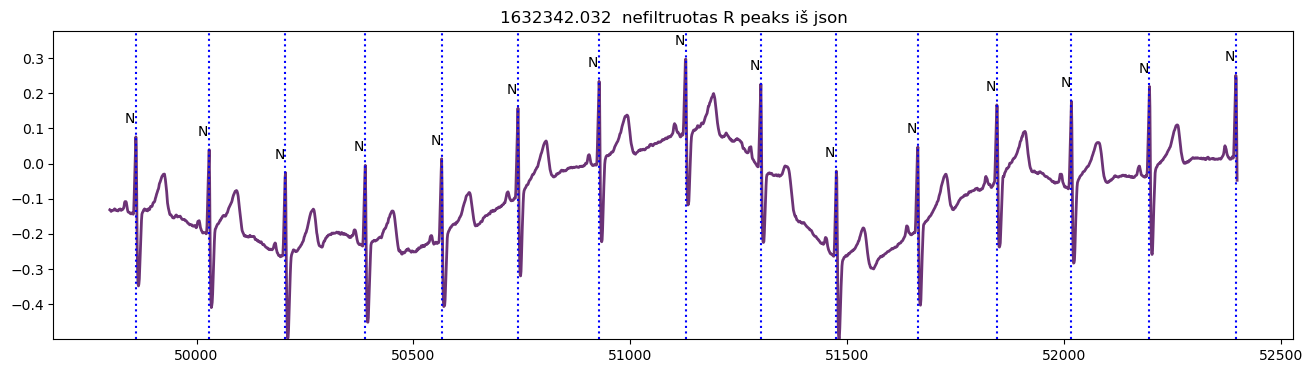

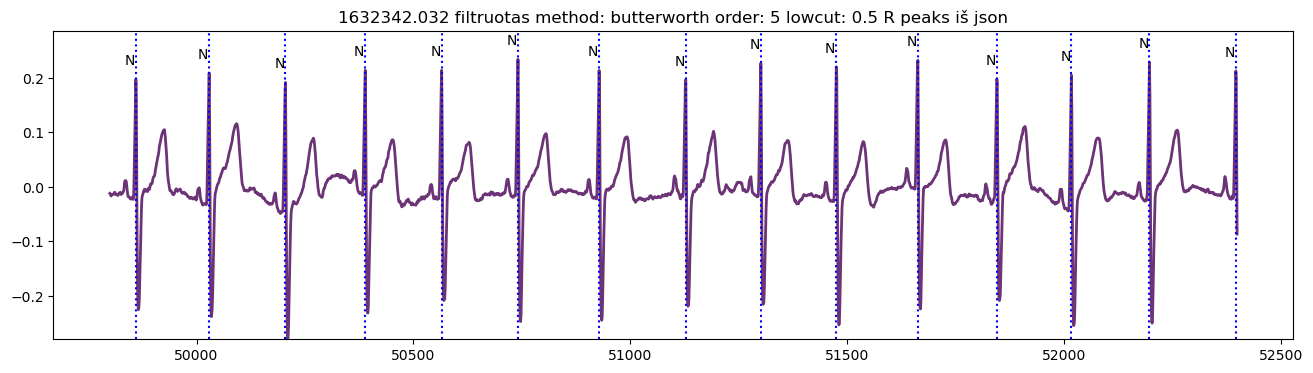

frag_nr = 3 52400 55000


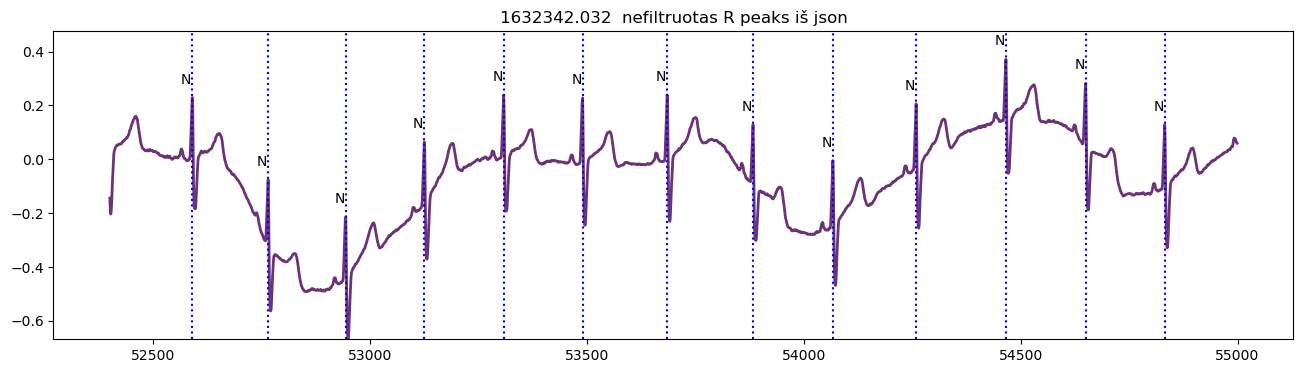

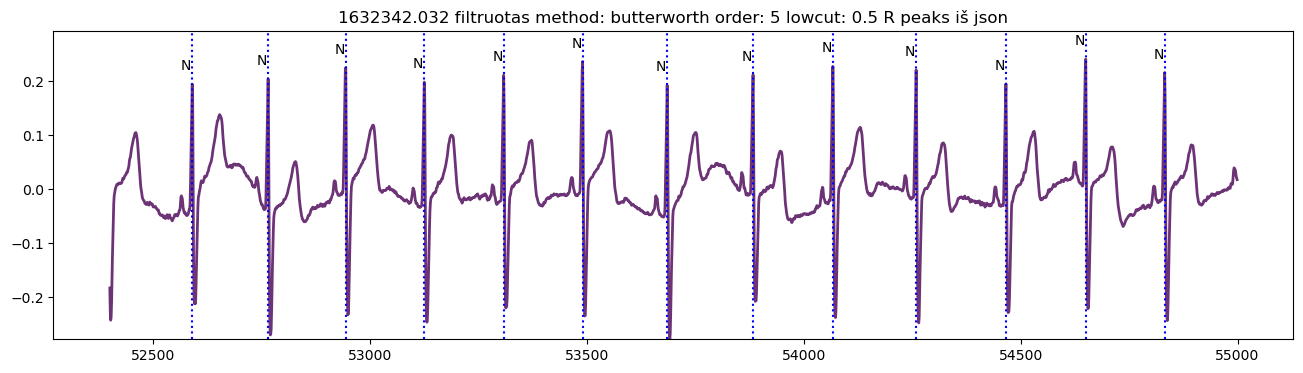

frag_nr = 4 55000 57600


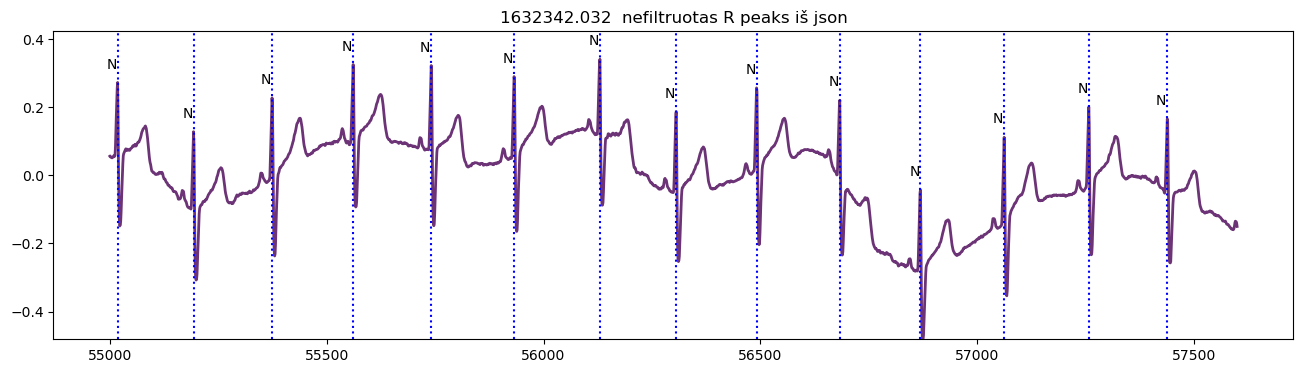

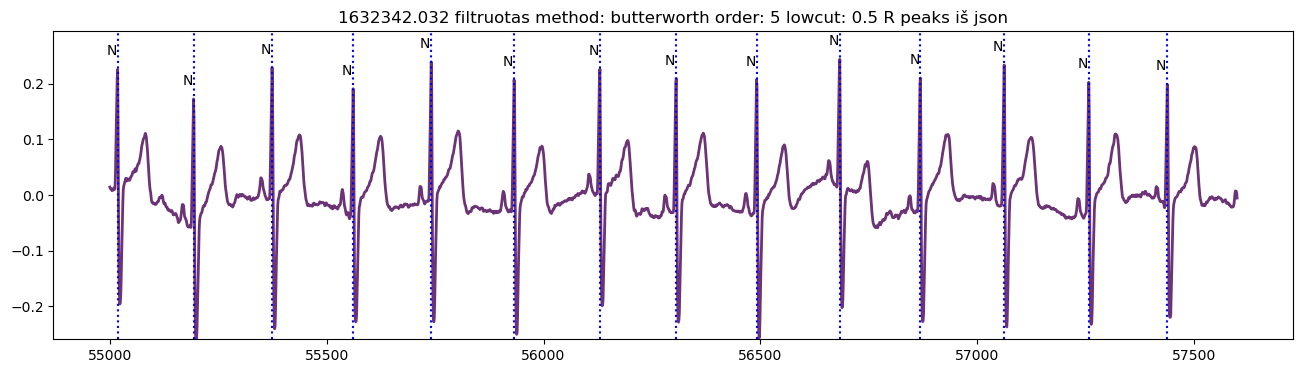

frag_nr = 5 57600 60200


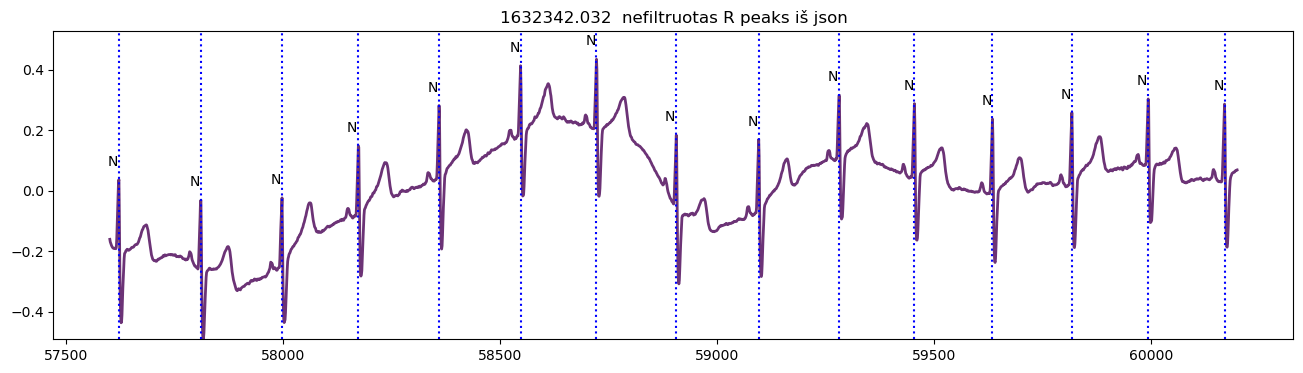

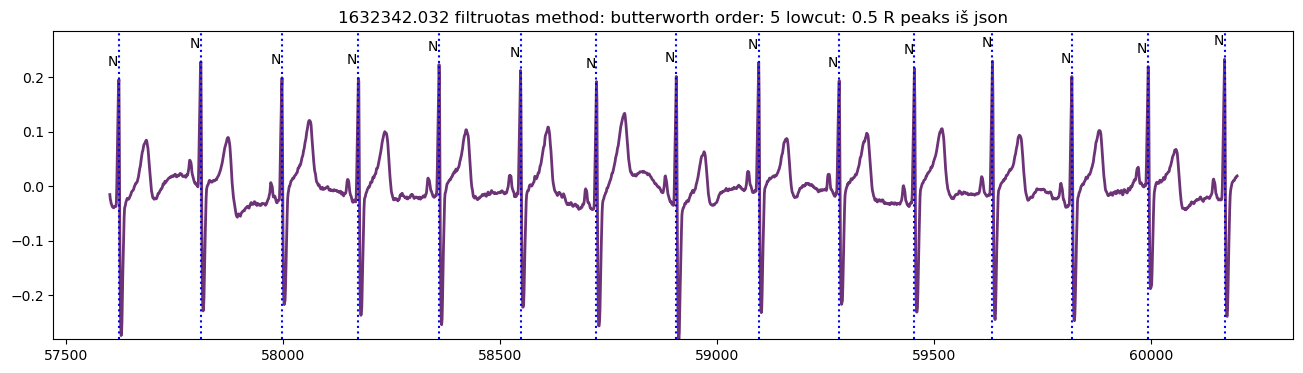

frag_nr = 6 60200 62800


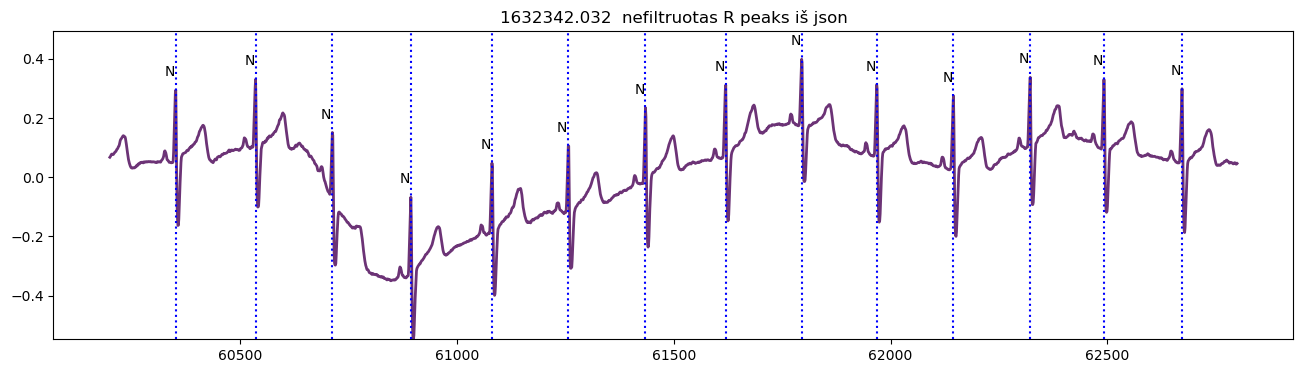

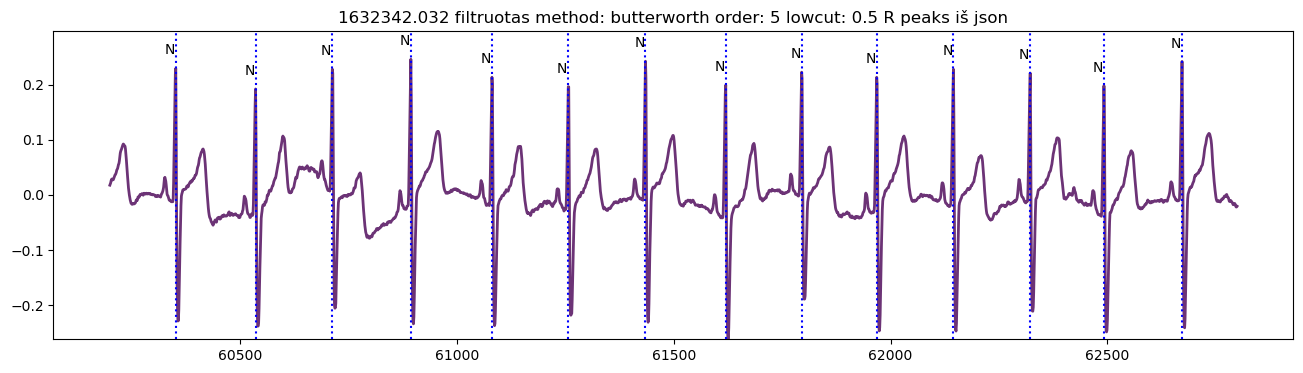

frag_nr = 7 62800 65400


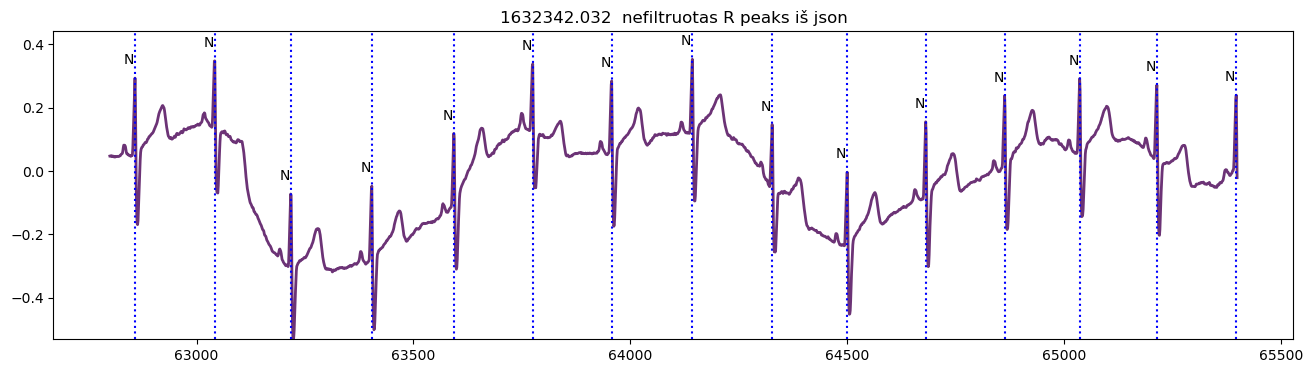

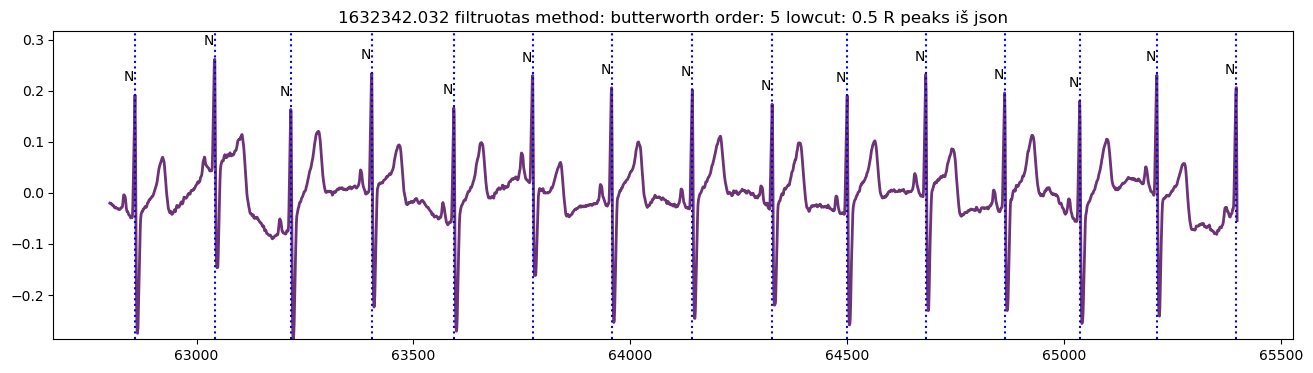

frag_nr = 8 65400 68000


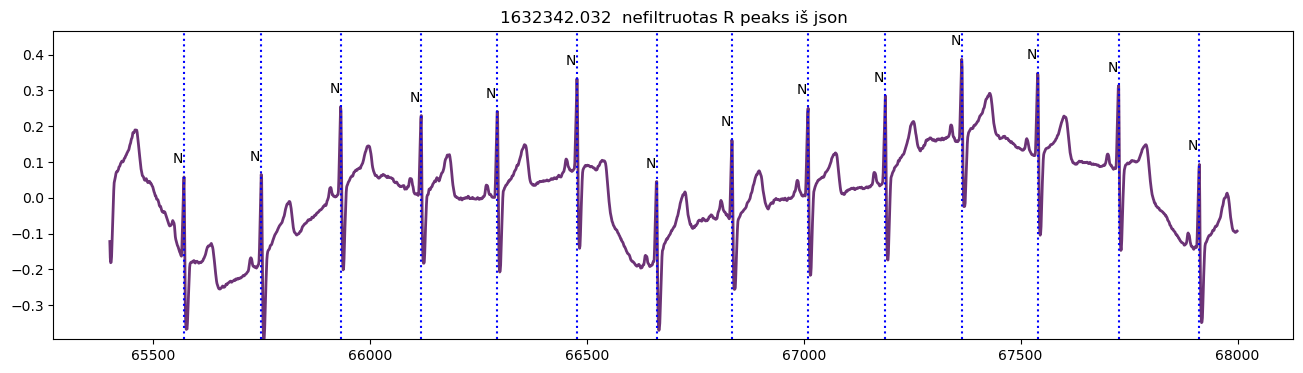

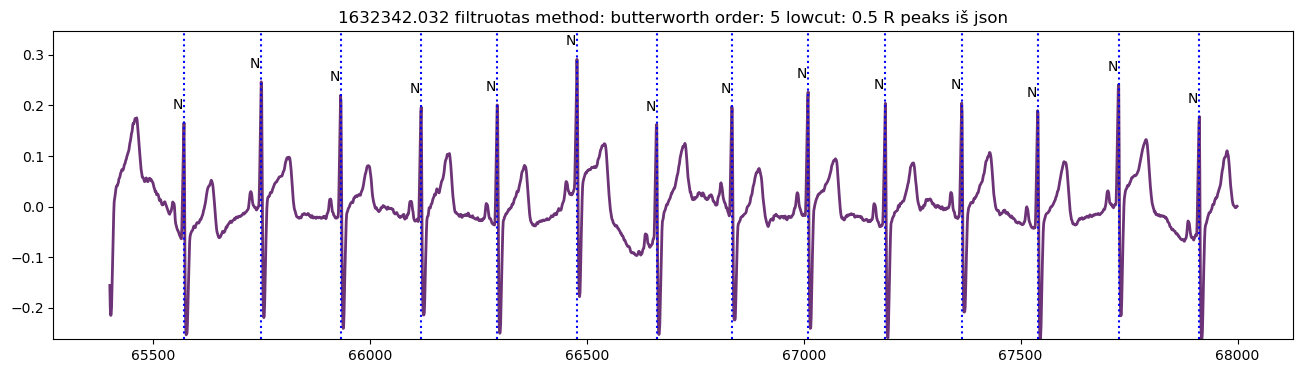

frag_nr = 9 68000 70600


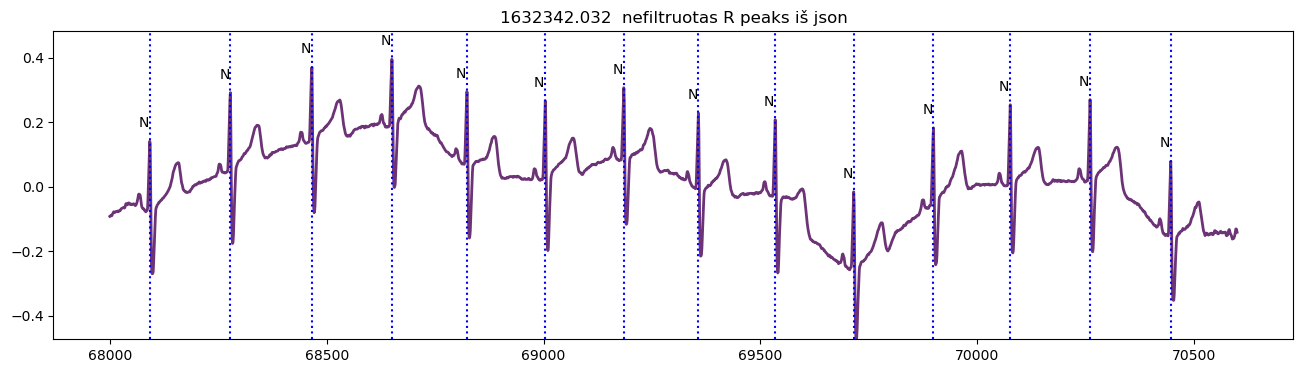

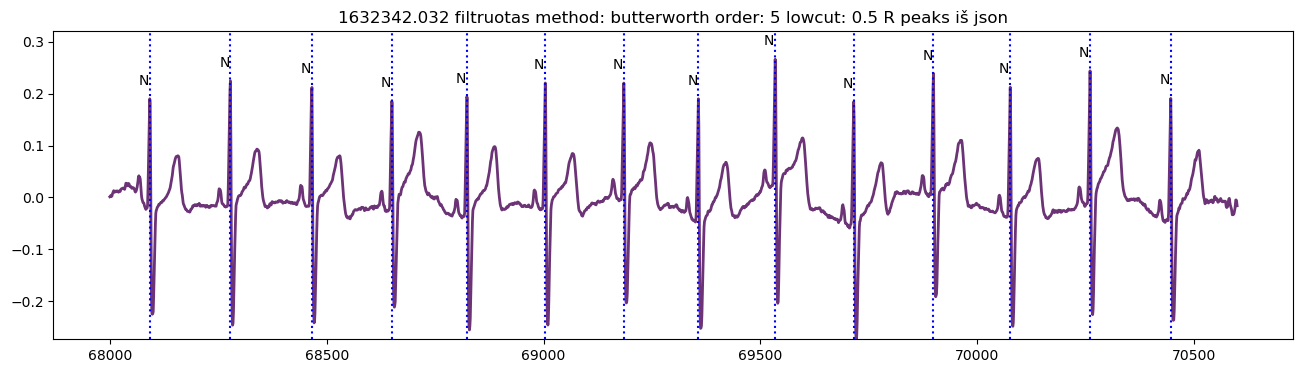

frag_nr = 10 70600 73200


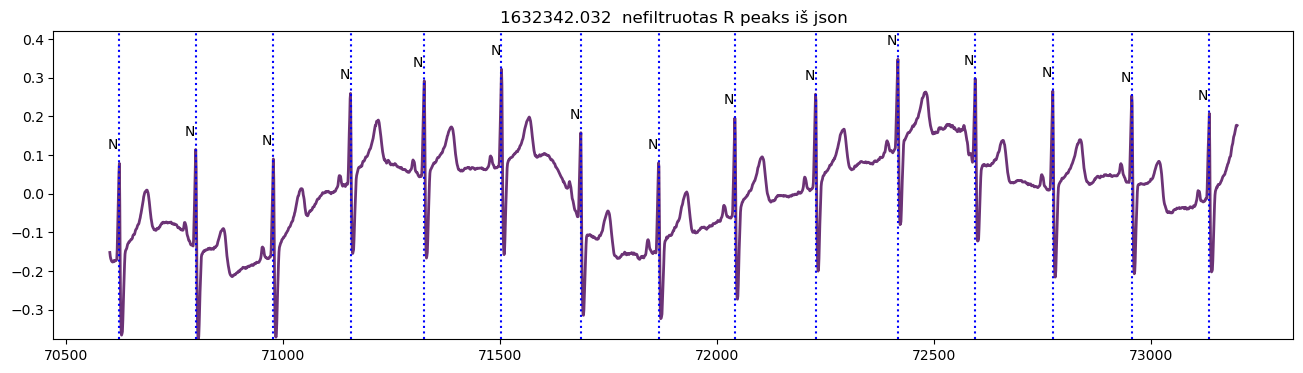

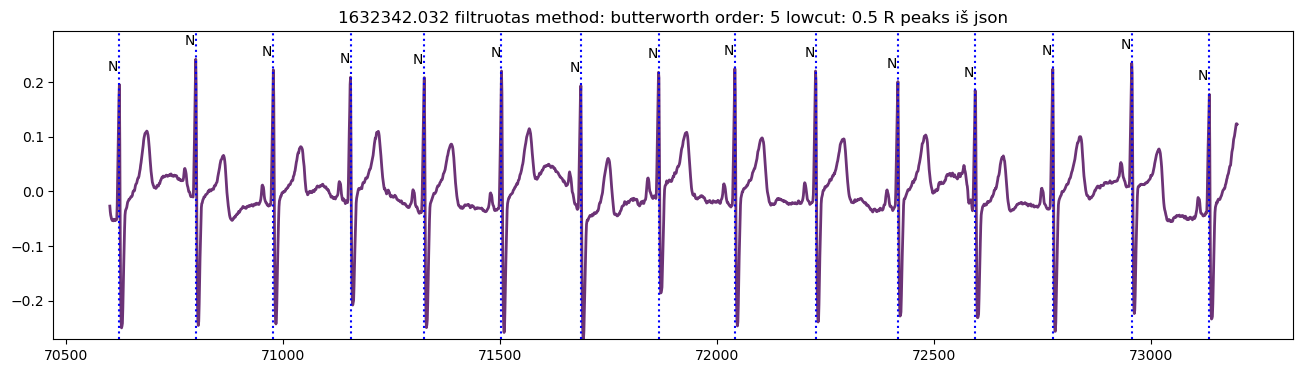

frag_nr = 11 73200 75800


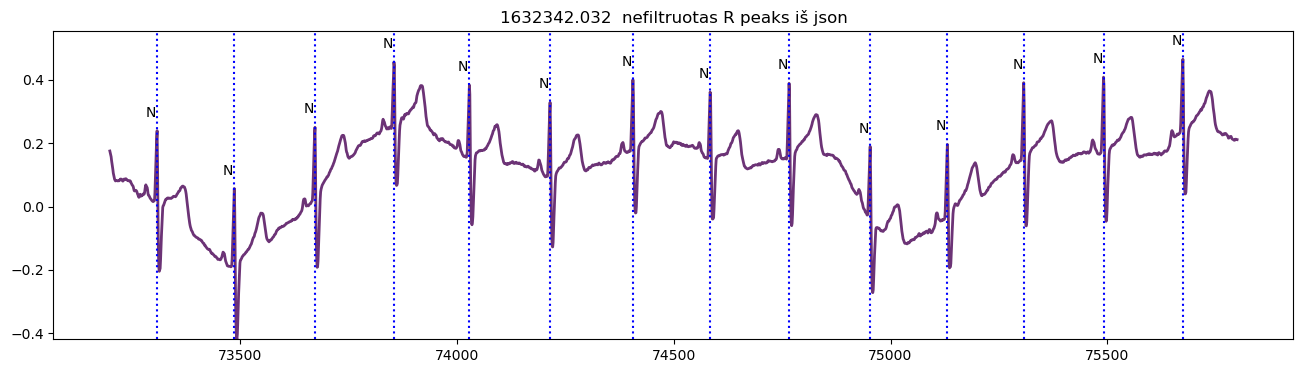

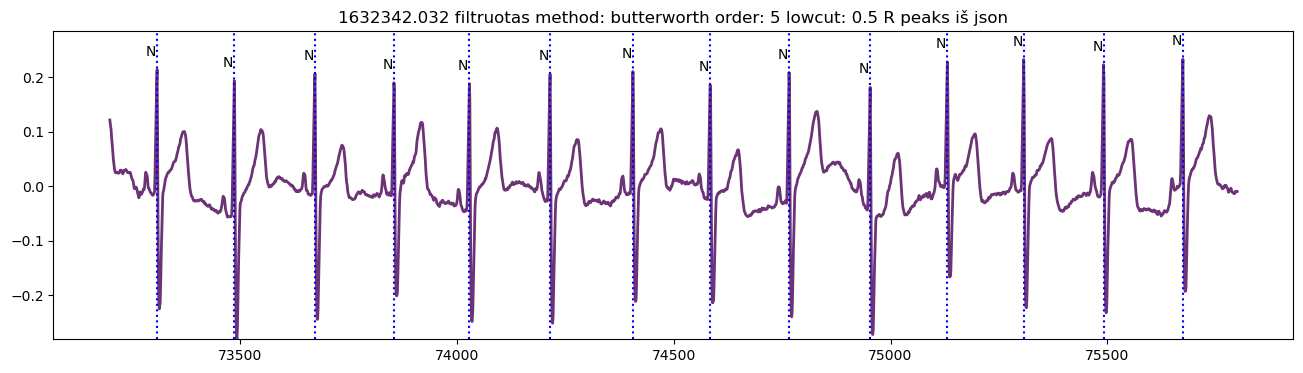

frag_nr = 12 75800 78400


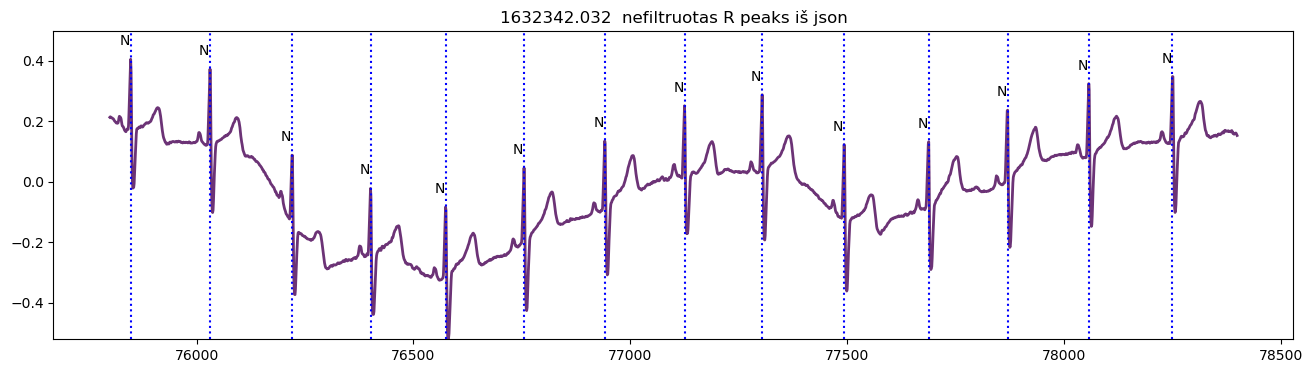

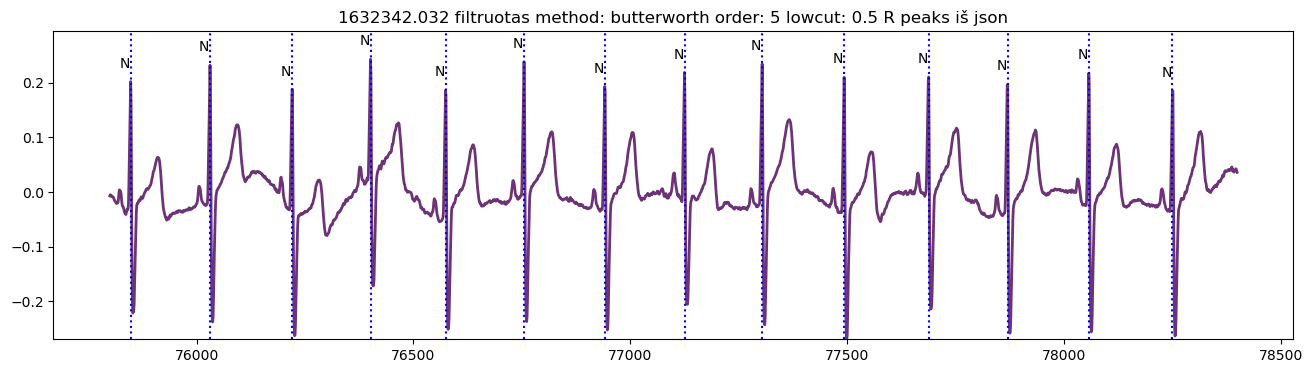

frag_nr = 13 78400 81000


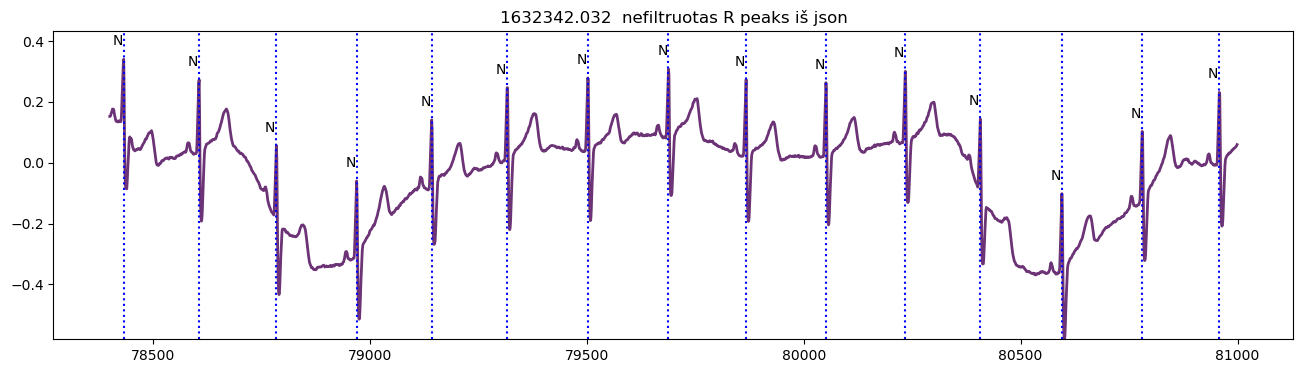

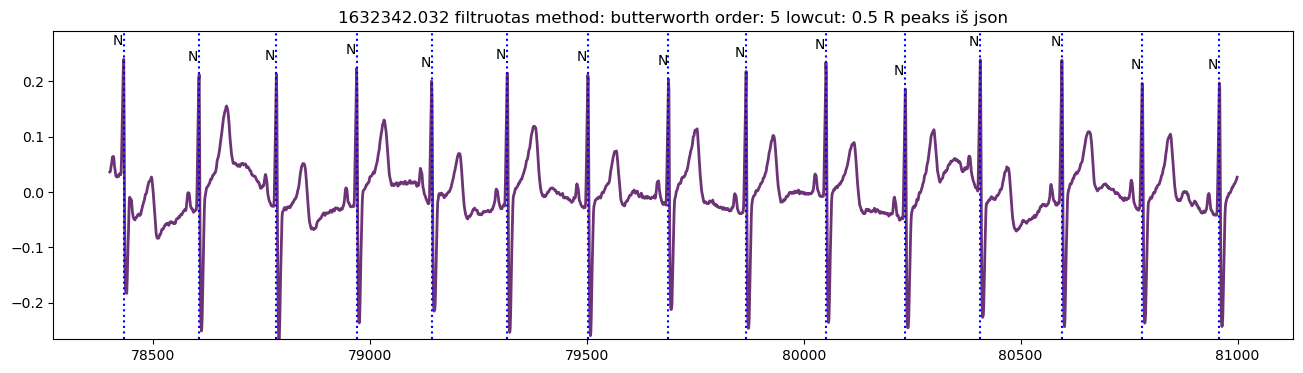

frag_nr = 14 81000 83600


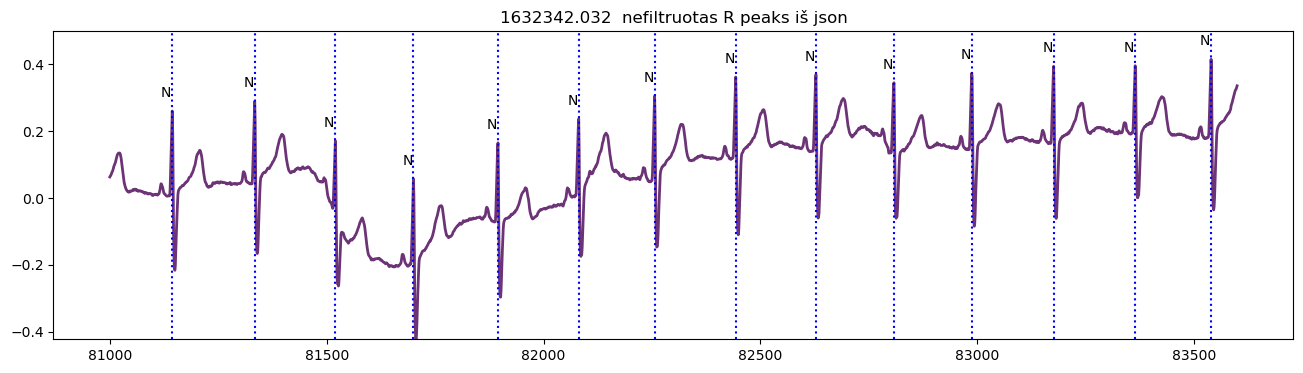

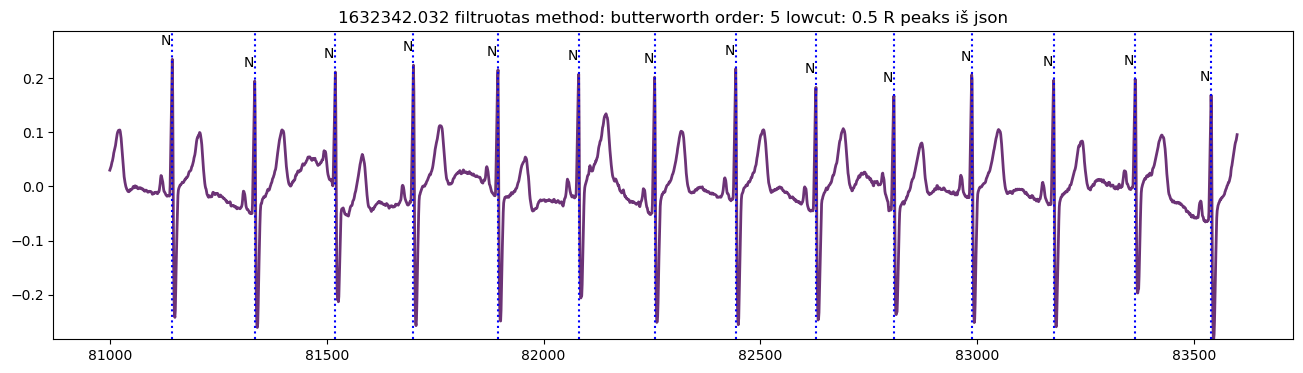

frag_nr = 15 83600 86200


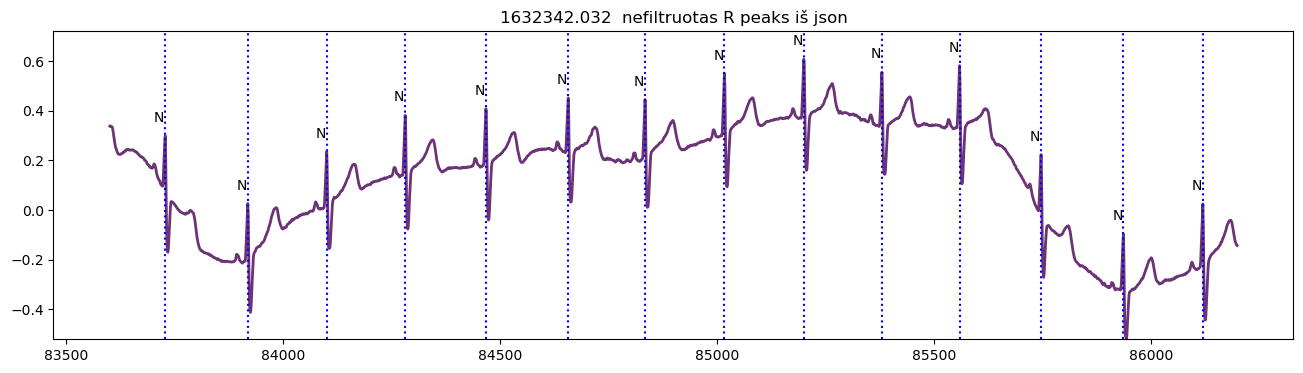

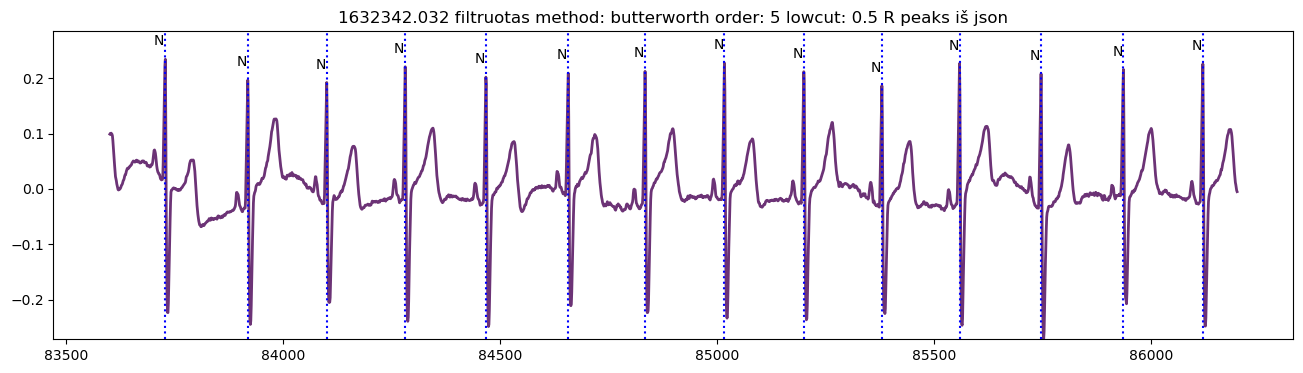

frag_nr = 16 86200 88800


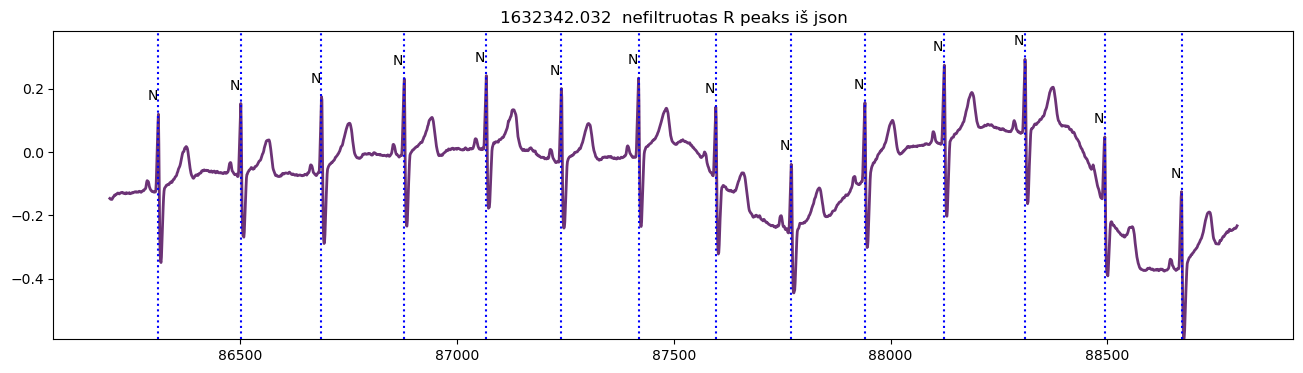

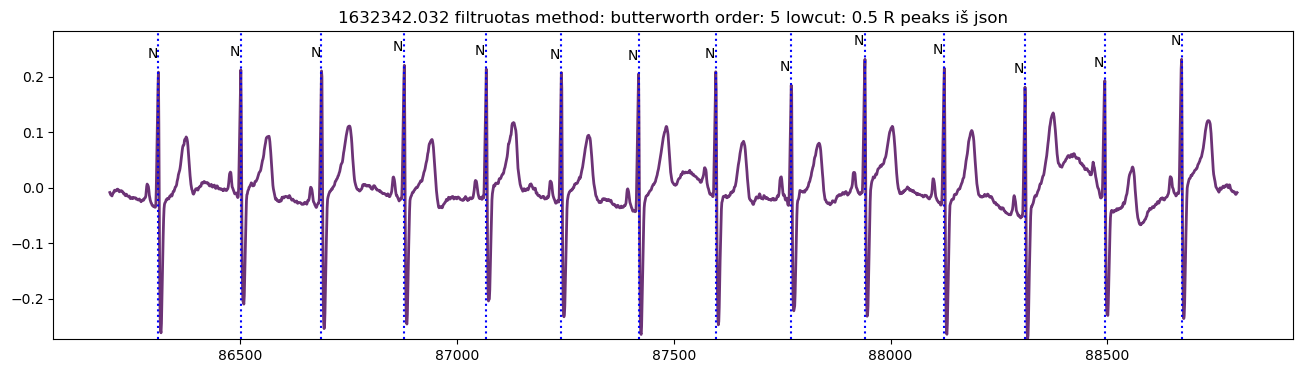

frag_nr = 17 88800 91400


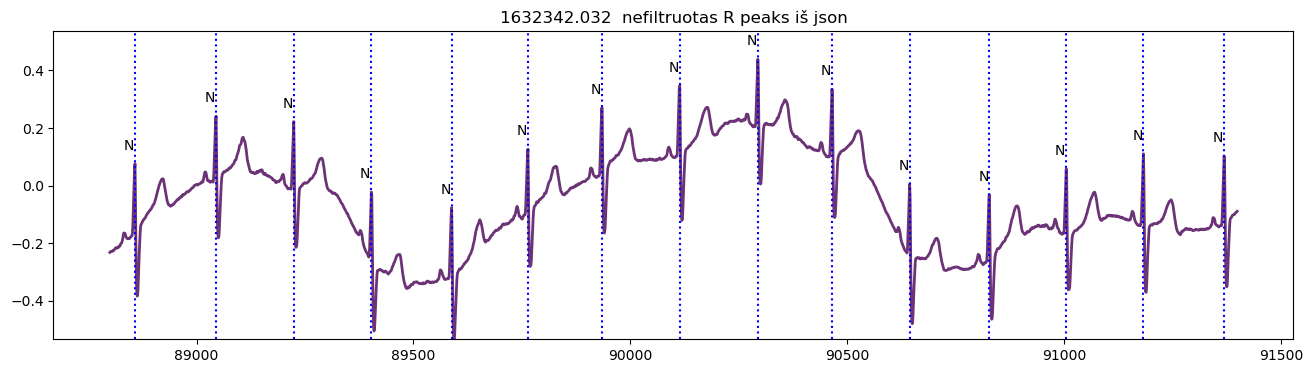

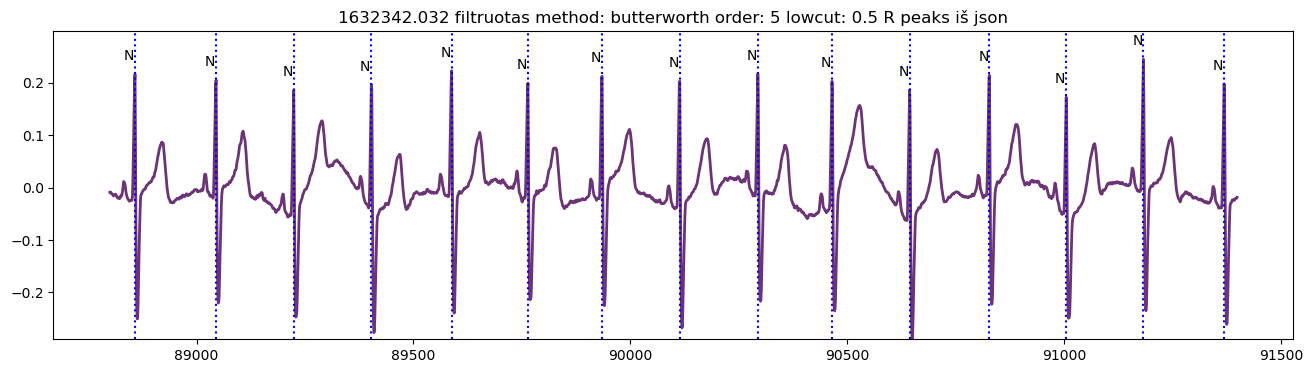

frag_nr = 18 91400 94000


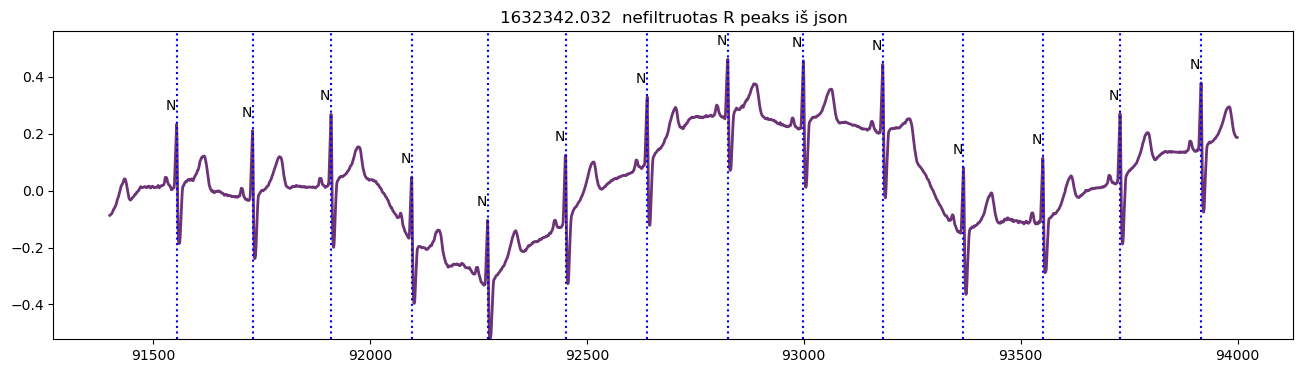

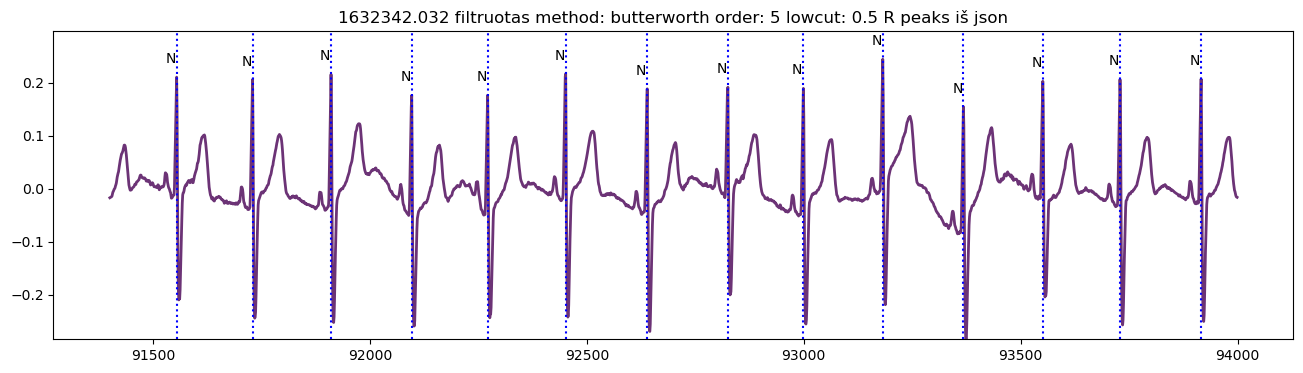

frag_nr = 19 94000 96600


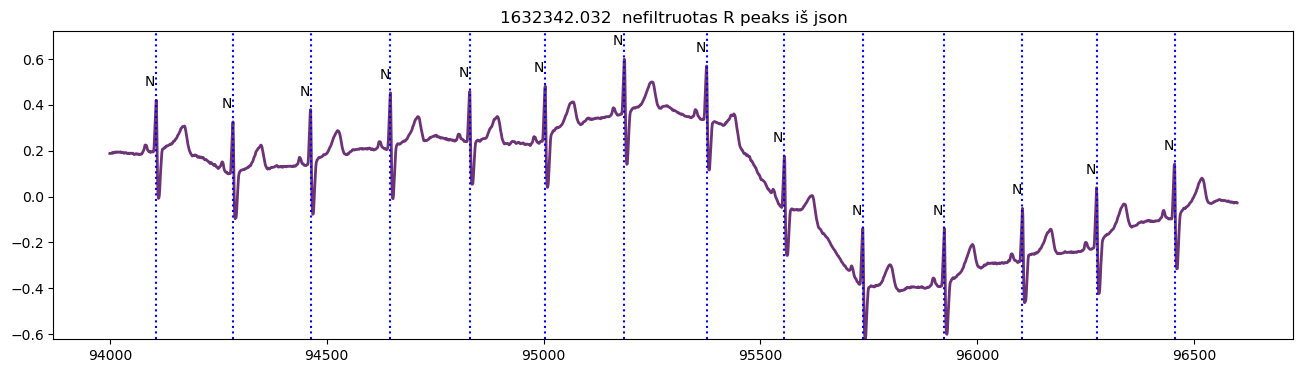

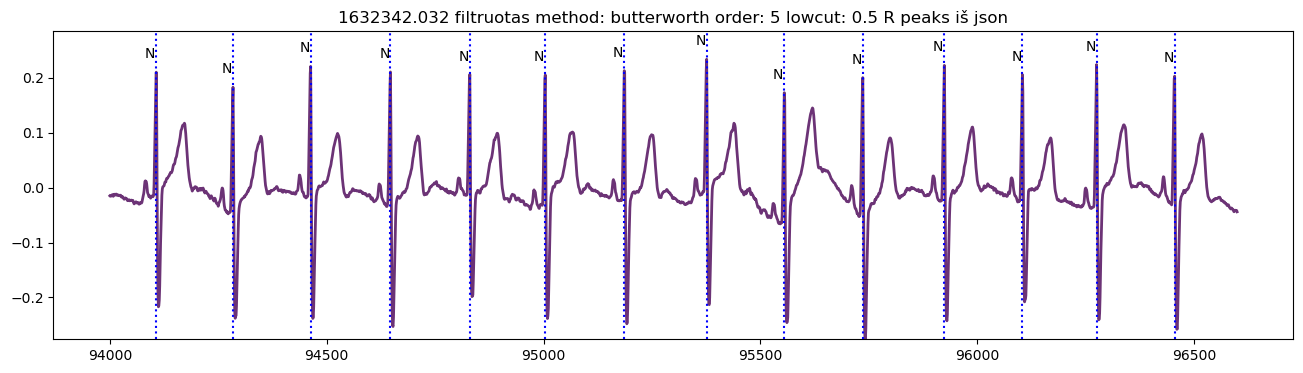

frag_nr = 20 96600 99200


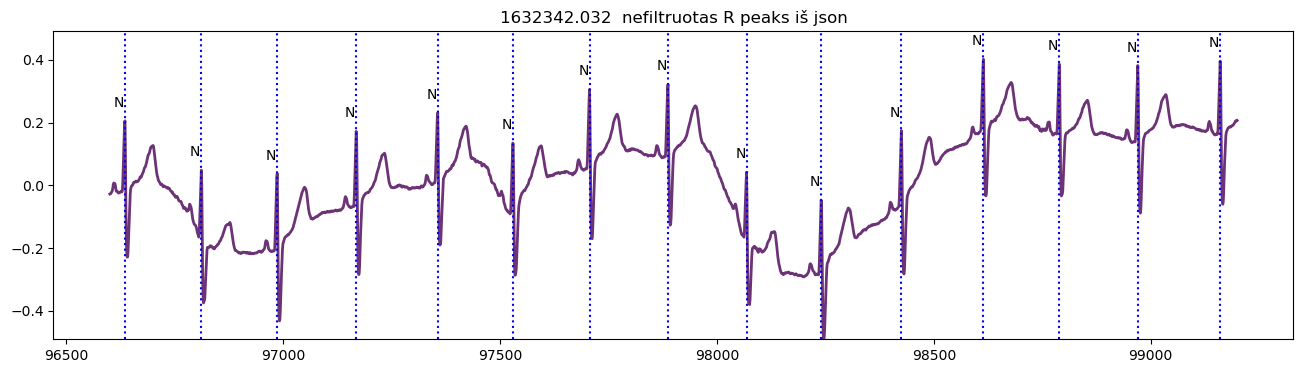

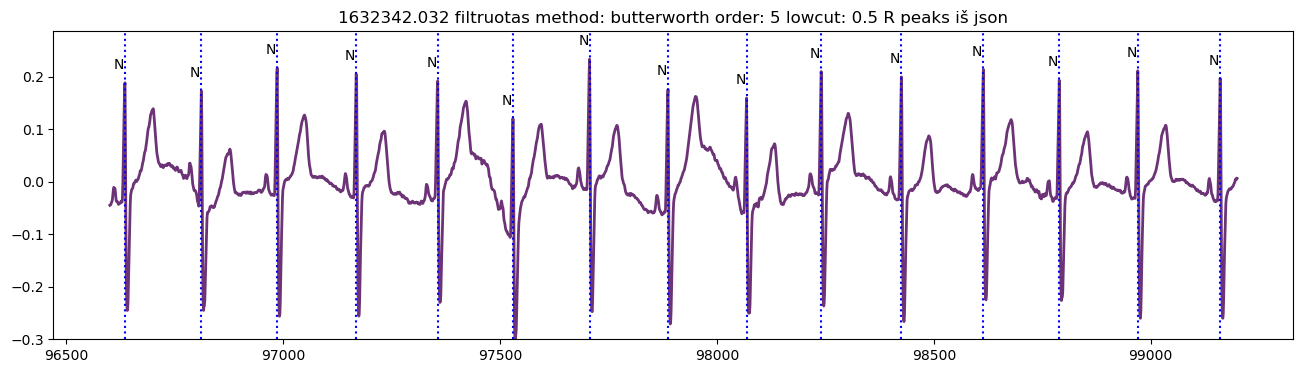

frag_nr = 21 99200 101800


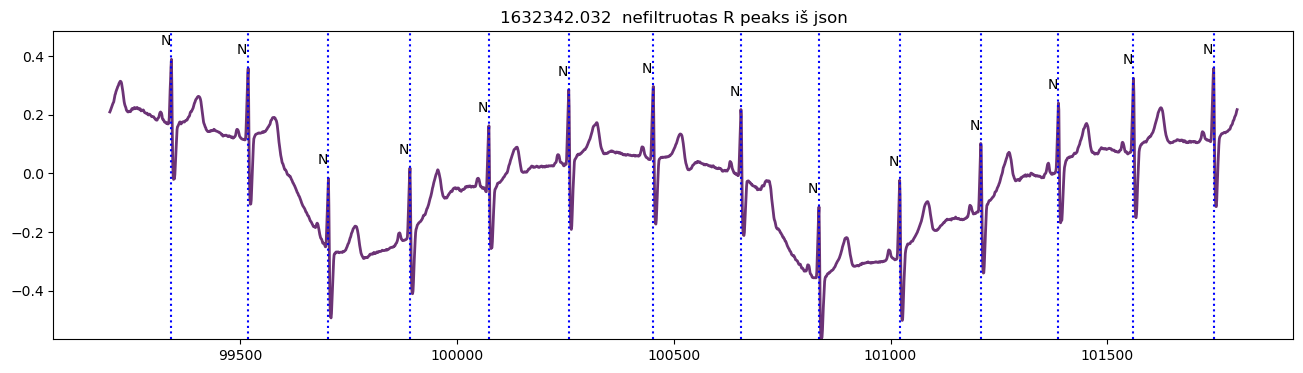

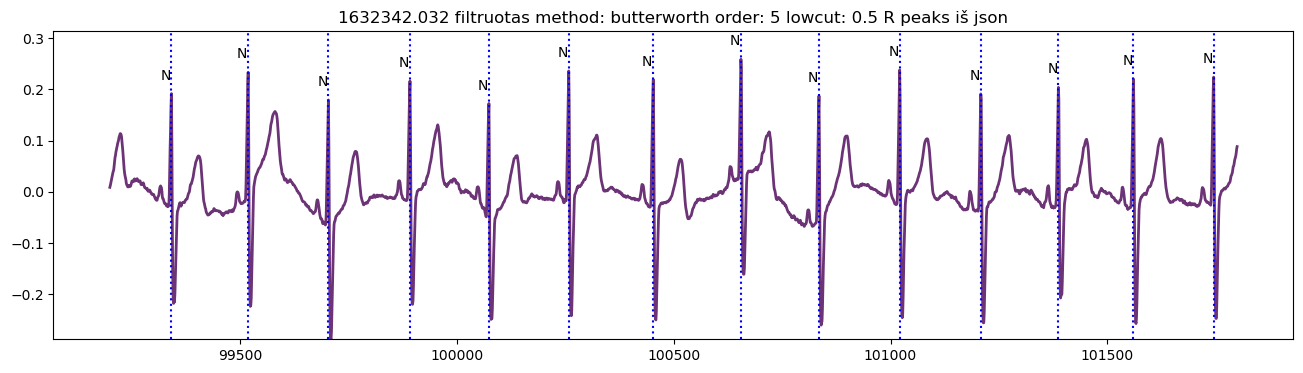

frag_nr = 22 101800 104400


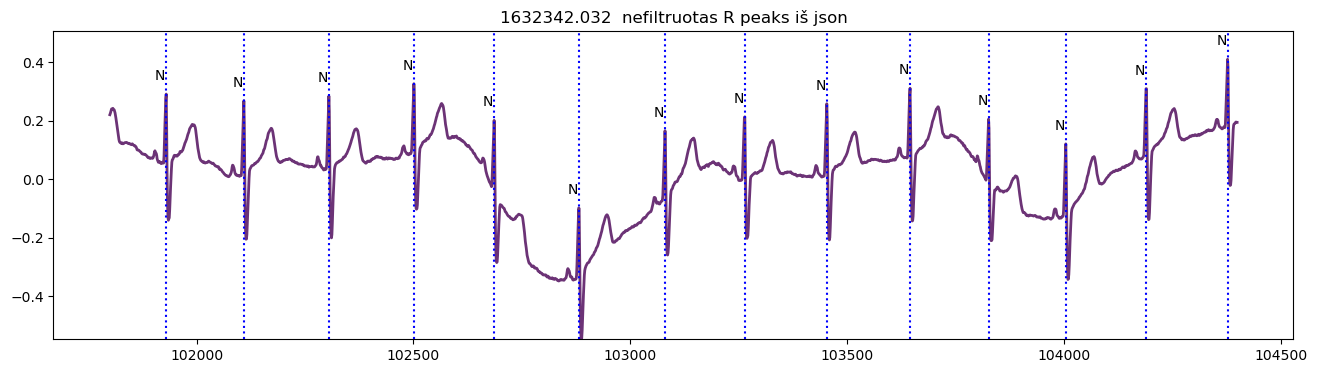

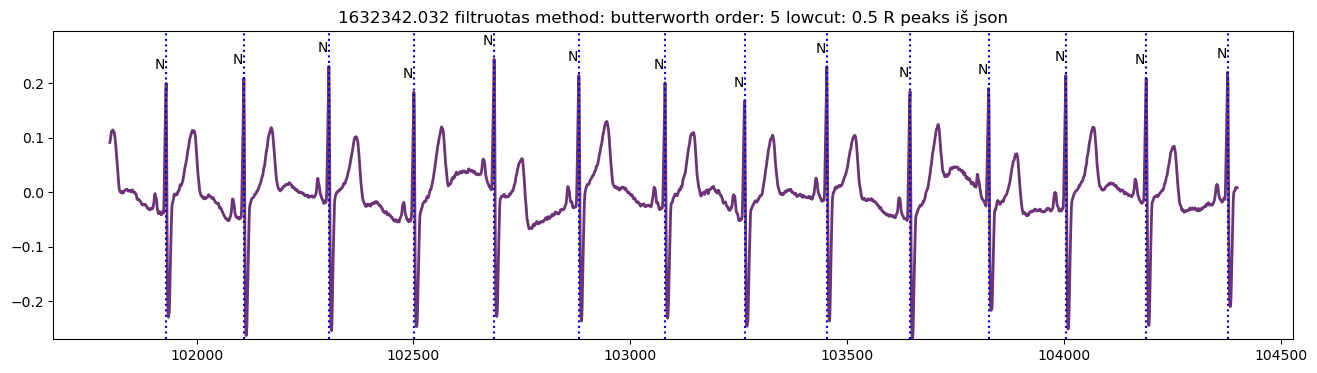

frag_nr = 23 104400 107000


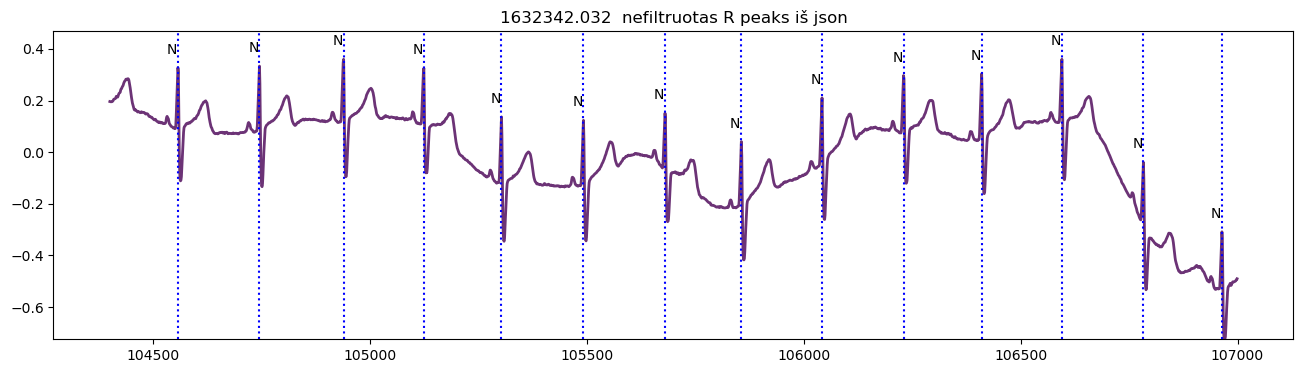

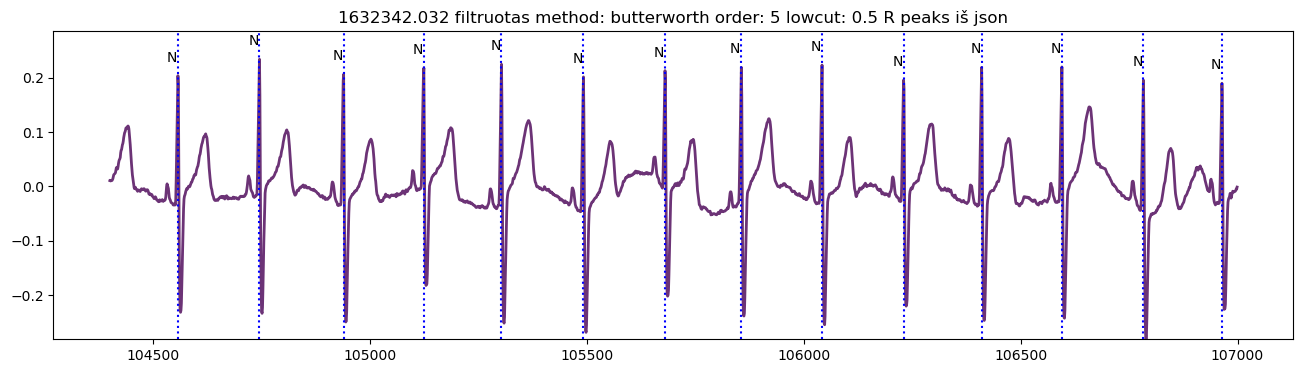

frag_nr = 24 107000 109600


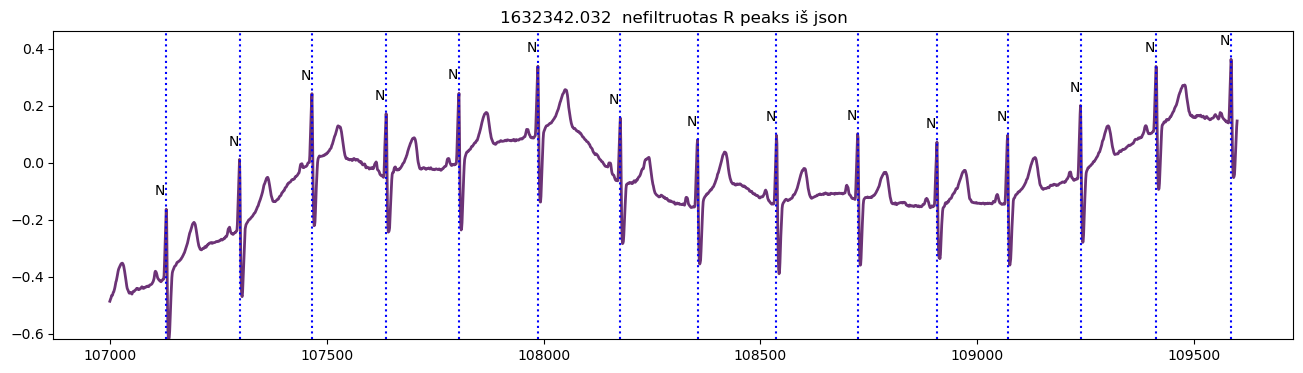

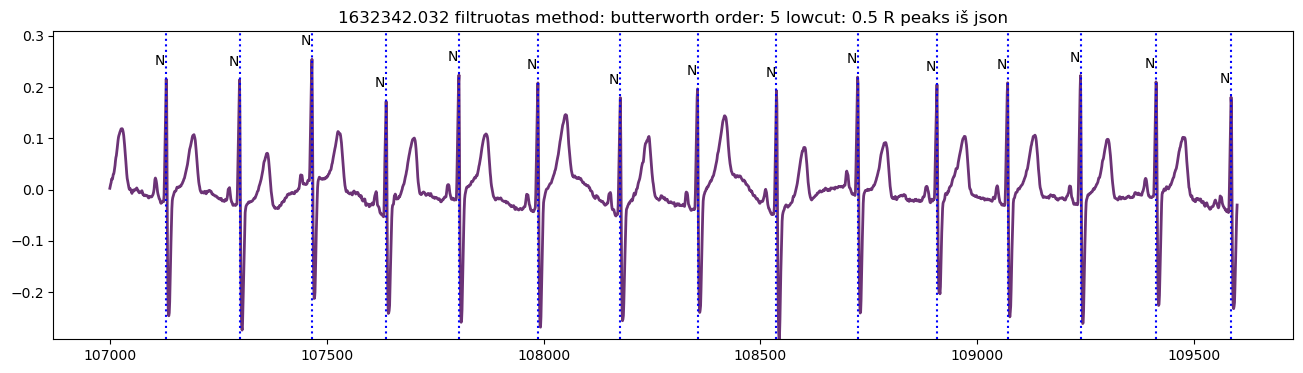

frag_nr = 25 109600 112200


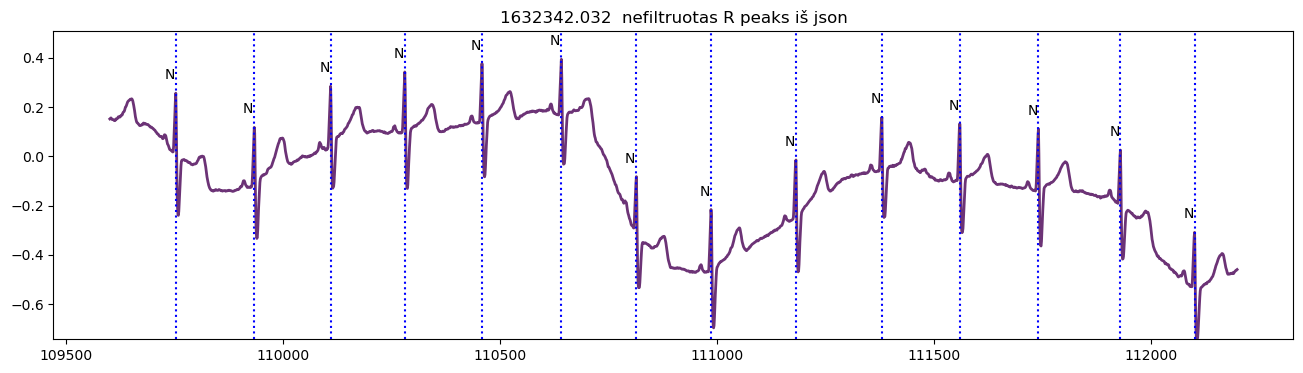

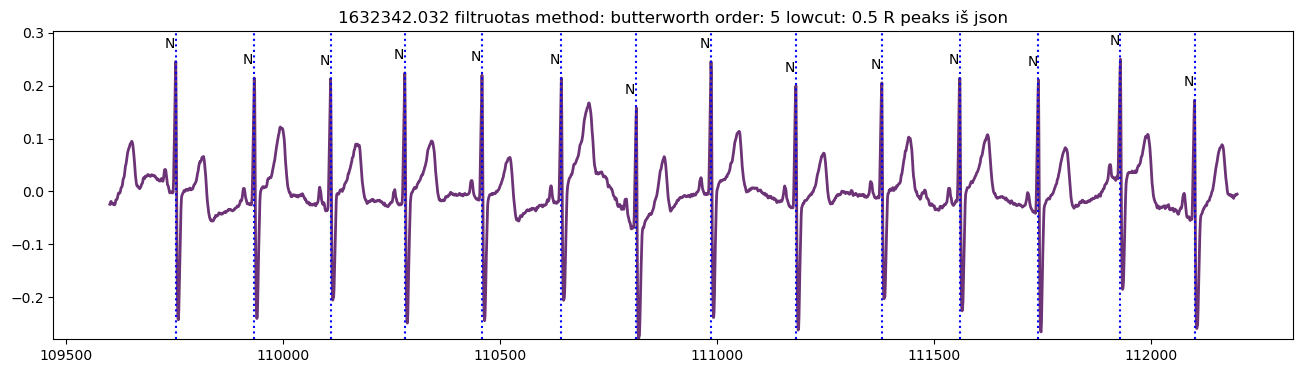

frag_nr = 26 112200 114800


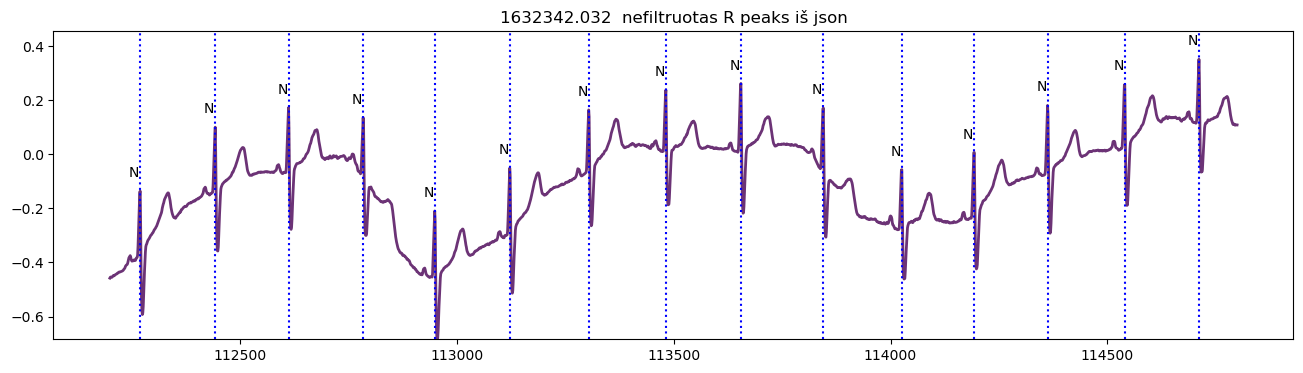

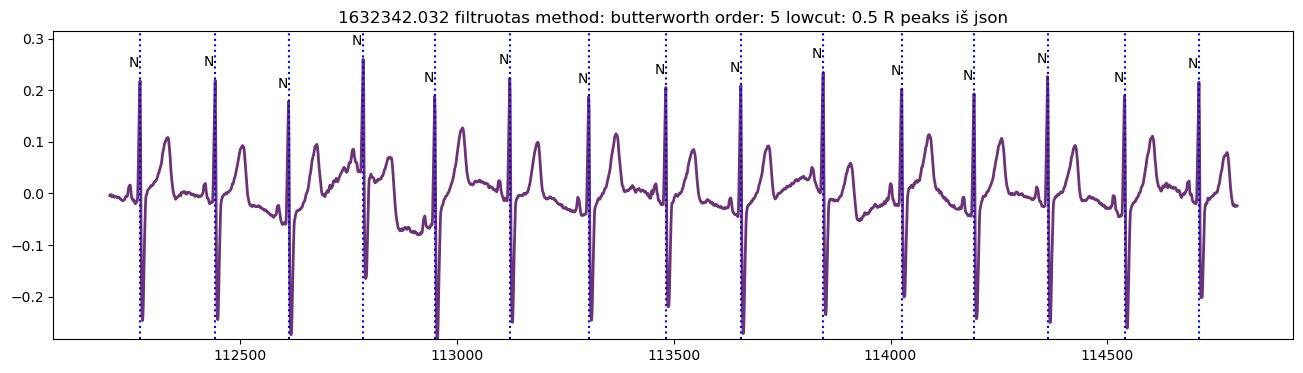

frag_nr = 27 114800 117400


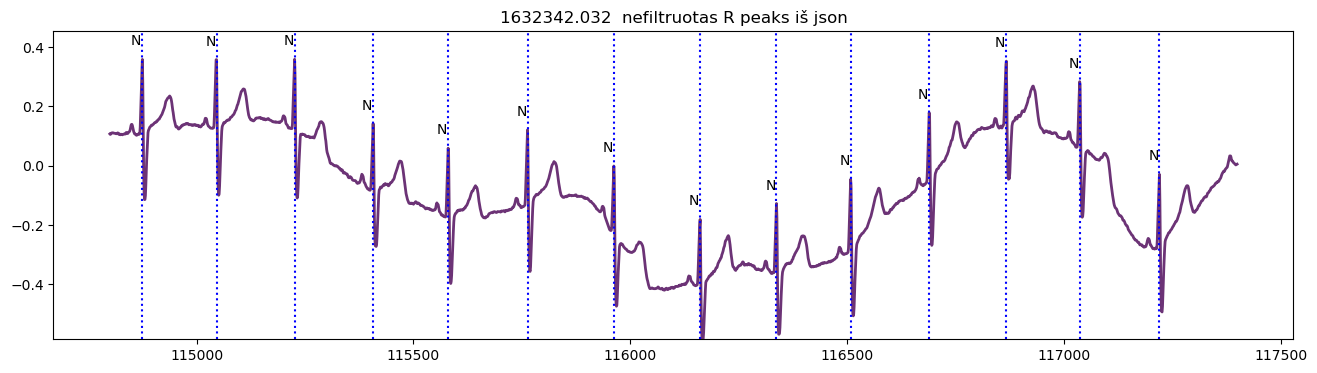

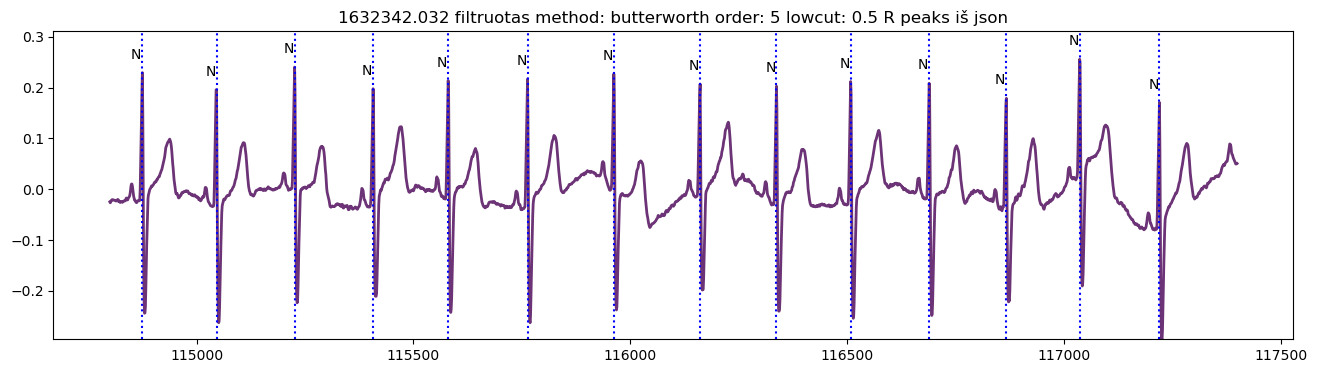

frag_nr = 28 117400 120000


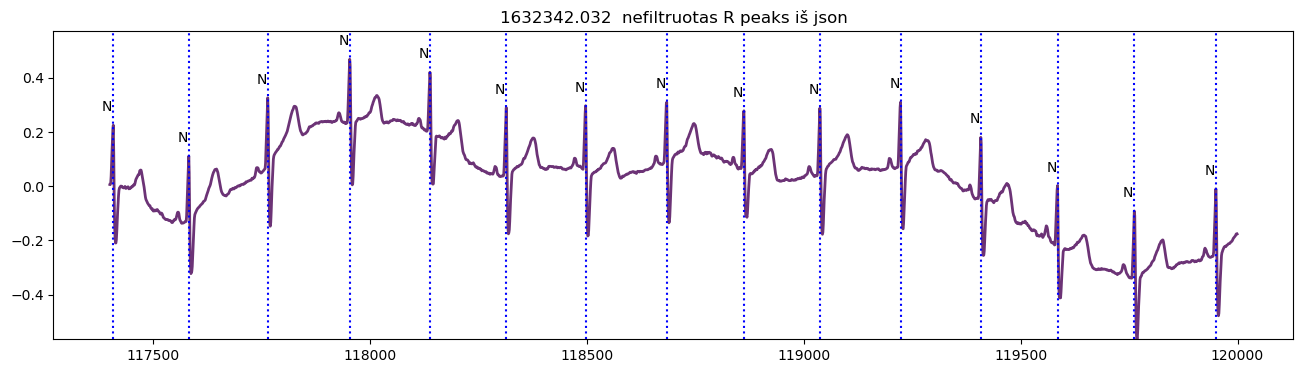

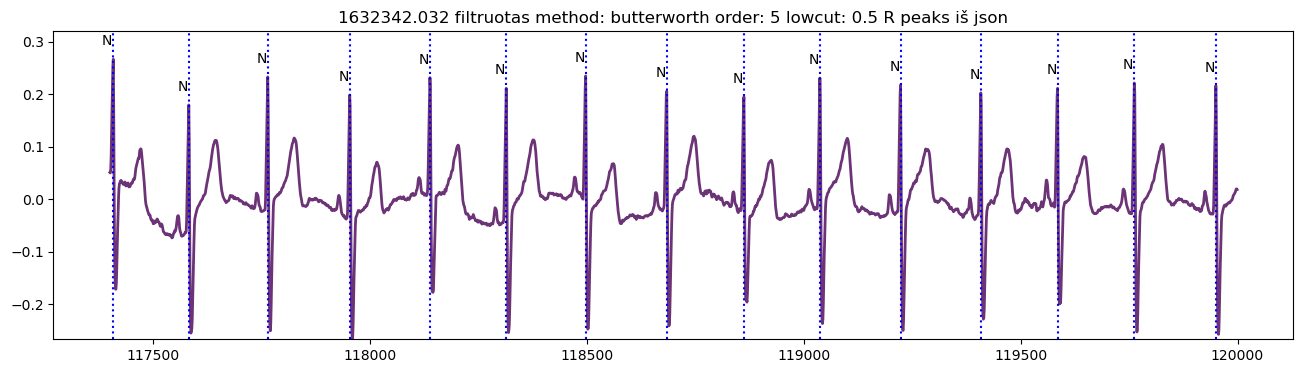

frag_nr = 29 120000 122600


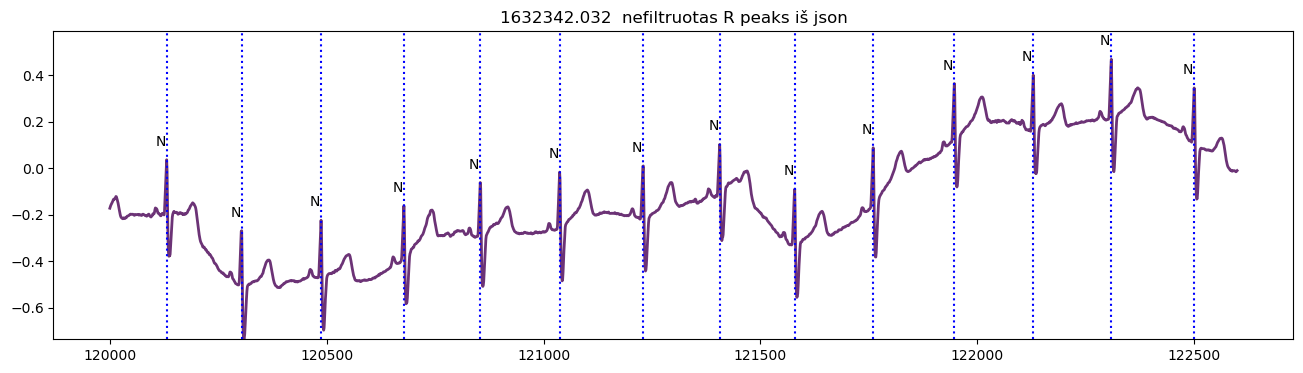

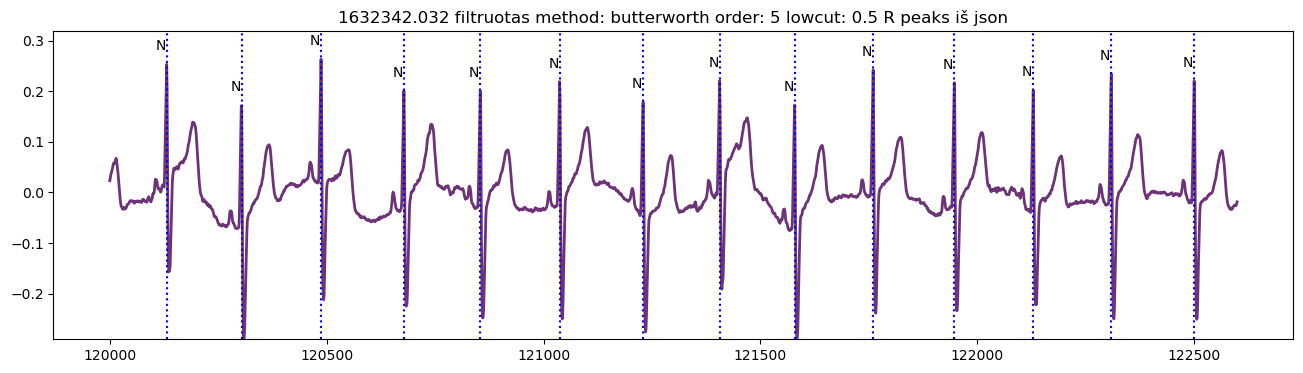

frag_nr = 30 122600 125200


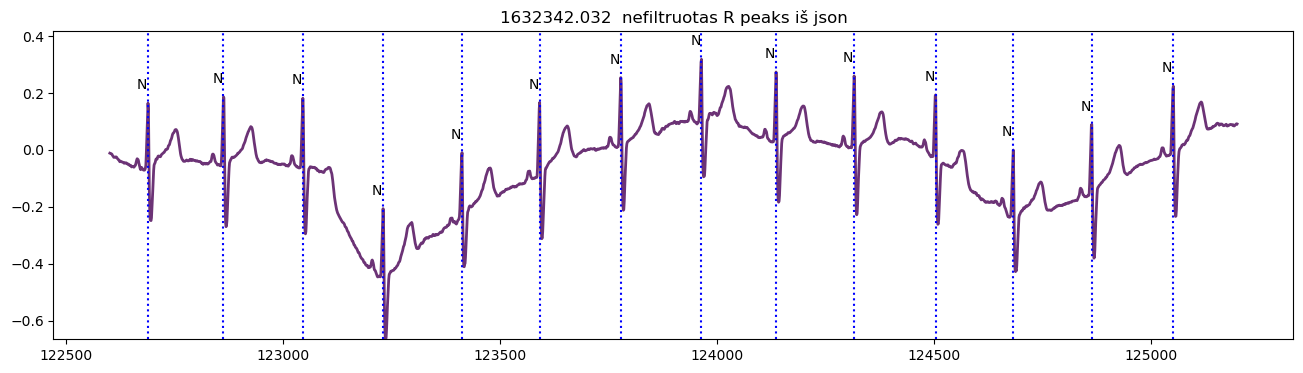

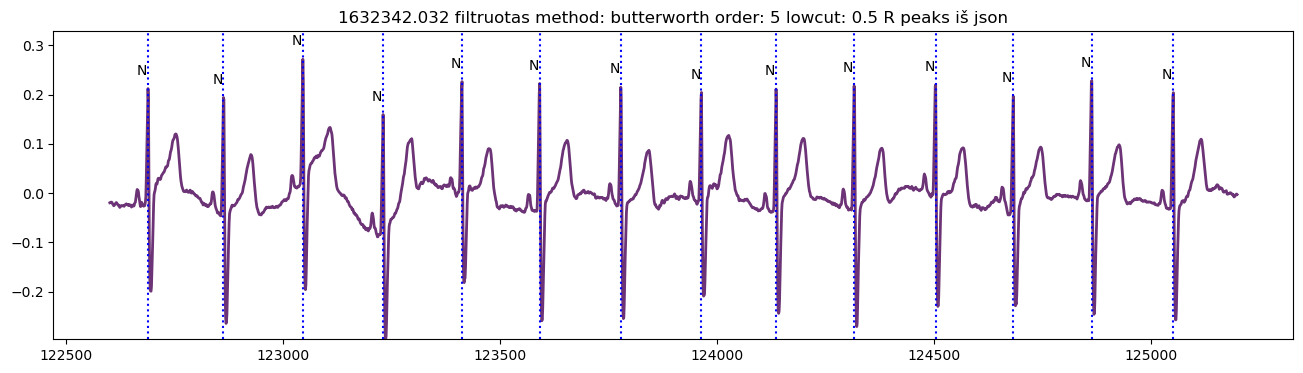

frag_nr = 31 125200 127800


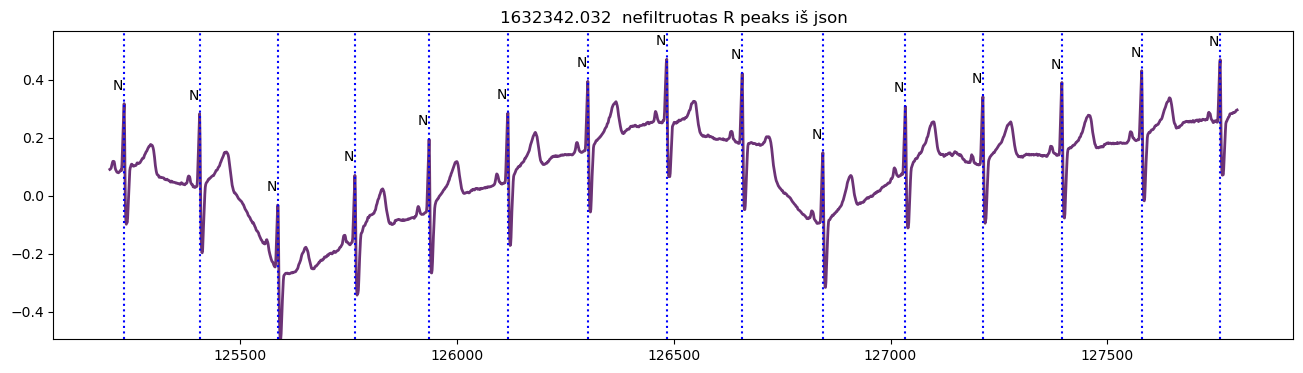

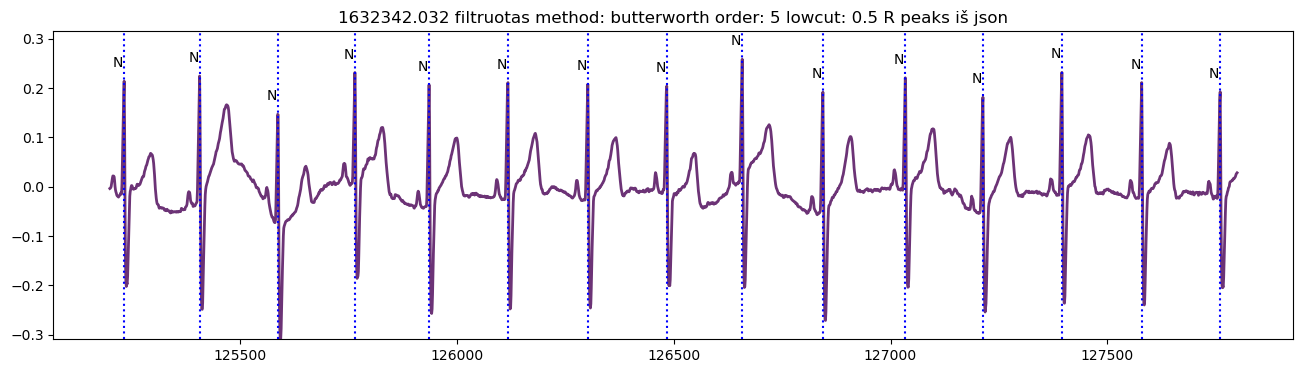

In [12]:
# Pagrindinis skriptas

print("\nScriptas ZIVE EKG filtravimo vizualiniam įvertinimui")
print("Duomenų rinkinys: ", rec_dir)

# Atrinkti failai pasižiūrėjimui
# Atrinkti failai pasižiūrėjimui
list = [1630947.302] # Vietomis daug triukšmų, panašu į kontaktinius
list = [1625408.182] # Triukšminga judant
list = [1636451.235] # Važinėjanti izolinija
list = [1631066.094] #Triukšmelis ties 9800, filtras 0.5 pagerina
list = [1637619.150] # Tinka demonstracijai. Labai važinėjanti izolinija, kartais staigiai, raumenų triukšmų palyginus nedaug 


# VARIANTAS, KAI UŽDUODAMI FAILŲ VARDAI IR SKAITOMI ORIGINALUS ZIVE FAILAI 
list = [
1626934.963,
1626931.201,
1630715.664,
1630714.569,
1630729.576,
1630735.143,
1630693.635,
1630734.526,
1630718.396,
1630721.49,
1631139.883,
1631083.411,
1631039.923,
1631029.786,
1632342.032,
1633428.56,
1633584.898,
1633405.853,
1634112.089,
1636451.86
]

list = [1637619.150] # Tinka demonstracijai. Labai važinėjanti izolinija, kartais staigiai, raumenų triukšmų palyginus nedaug 
list = [1631039.923] # Nuo 61200 prasideda aiškiai matomi raumenų triukšmai, 82400, 112000 ir dr keletą vietų - intensyvus izolinijos makalavimasis 

list = [1632342.032] # iš test 20, Zilvino nr.4
file_names=["%.3f" % i for i in list]

file_name = file_names[0]
print(f"\nZive įrašas:  {file_name:>2}")

 # I-a dalis: nuskaitome EKG įrašą, suformuojame rpeaks su Neurokitu,
 # pakartojant Zive skriptą iš analysis.py ir heartrate_analysis.py
filepath = Path(rec_dir, file_name)
sign_raw = zive_read_file_1ch(filepath)
ecg_signal_df = pd.DataFrame(sign_raw, columns=['orig'])

# analysis_results = AnalyseHeartrate(ecg_signal_df)
# rpeaks_from_signal = analysis_results['rpeaks']
# len_rpeaks = len(rpeaks_from_signal)
# rpeaks_symbols = np.full(shape=len_rpeaks, fill_value='R', dtype=str)
# print(f"rpeaks iš signal: {len_rpeaks}")

# print(rpeaks_from_signal[:10])
# print(rpeaks_symbols[:10])

signal_length = sign_raw.shape[0]
print('signal_length= ', signal_length, sign_raw.shape)
if (frag_end_fixed == None or frag_end_fixed > signal_length):
    frag_end_fixed = signal_length

frag_number = int((frag_end_fixed-frag_start_fixed)/frag_window)
if frag_number == 0:
    frag_number =1
    frag_window = signal_length-frag_start_fixed

print("Vaizduojamos reikšmės intervale:", frag_start_fixed, frag_end_fixed)
print("Lango plotis: ", frag_window, "Langų: ", frag_number)

# Išlyginame izoliniją
fp = {  'method':'butterworth',
        'order':5,
        'lowcut':0.5,
         'highcut':20 }


print(f"\nIšlyginta izolinija su {fp['method']}")
# Žemų dažnumų filtras
flt_param = f"method: {fp['method']} order: {fp['order']} lowcut: {fp['lowcut']}"
sign_filt = signal_filter(signal=sign_raw, sampling_rate=200, lowcut=fp['lowcut'], method=fp['method'], order=fp['order'])

# Aukštų dažnumų filtras
# flt_param = f"method: {fp['method']} order: {fp['order']} highcut: {fp['highcut']}"
# sign_filt = signal_filter(signal=sign_raw, sampling_rate=200, highcut=fp['highcut'], method=fp['method'], order=fp['order'])

# Juostinis filtras
# flt_param = f"method: {fp['method']} order: {fp['order']} lowcut: {fp['lowcut']} highcut: {fp['highcut']}"
# sign_filt = signal_filter(signal=sign_raw, sampling_rate=200, lowcut= fp['lowcut'], highcut=fp['highcut'], method=fp['method'], order=fp['order'])



# II-a dalis: Nuskaitome paciento anotacijas ir jų indeksus

df_rpeaks = zive_read_df_data(rec_dir, file_name, 'rpeaks')
if (df_rpeaks.empty == True):
    print(f'Annotation file for {file_name} does not exist or nrpeaks is empty!')
else:
    atr_sample = df_rpeaks['sampleIndex'].to_numpy()
    atr_symbol = df_rpeaks['annotationValue'].to_numpy()

# print(f"rpeaks iš json: {len(atr_sample)}")

# print(atr_sample[:10])
# print(atr_symbol[:10])

counts = df_rpeaks['annotationValue'].value_counts(sort = True, ascending = True)
# print(counts)

# Anotacijų skaičius įraše
lst = {}
for idx,name in enumerate(df_rpeaks['annotationValue'].value_counts().index.tolist()):
    counts = df_rpeaks['annotationValue'].value_counts()[idx]
    lst[name] = counts
print("\nAnotacijų įraše (F ir U ignoruojamos):")
print(lst)

# Galime pažiūrėti, kur yra anotacijos
print("\nAnotacijų S vietos:", anotacijos(df_rpeaks,"S"))
print("\nAnotacijos V:",anotacijos(df_rpeaks,"V"))

frag_start = frag_start_fixed
frag_end = frag_start + frag_window
if (frag_end > frag_end_fixed):
    frag_end = frag_end_fixed

for frag_nr in range(frag_number):
    # 'Išpjauname' seką ir atvaizduojame
    print('frag_nr =', frag_nr, frag_start, frag_end)
    
    # Vaizduojame nefiltruotą su rpeaks iš json failo
    fig = plt.figure(figsize=(16,4),facecolor=(1, 1, 1))
    ax = show_seq_ext_zive(sign_raw, atr_sample, atr_symbol, frag_start, frag_end, window_left_side, window_right_side, win_flag)
    ax.set_title(file_name + '  nefiltruotas' + ' R peaks iš json')
    # plt.savefig(file_path, bbox_inches='tight', pad_inches = 0.2)
    plt.show()

 # Vaizduojame filtruotą su rpeaks iš json failo
    fig = plt.figure(figsize=(16,4),facecolor=(1, 1, 1))
    ax = show_seq_ext_zive(sign_filt, atr_sample, atr_symbol, frag_start, frag_end, window_left_side, window_right_side, win_flag)
    ax.set_title(file_name + ' filtruotas ' +  flt_param + ' R peaks iš json')
    # plt.savefig(file_path, bbox_inches='tight', pad_inches = 0.2)
    plt.show()
    
    frag_start += frag_window
    frag_end += frag_window
    if (frag_end > signal_length):
        frag_end = signal_length
